In [1]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
import torch.nn as nn
import matplotlib
from PIL import Image, ImageOps

matplotlib.rcParams['figure.figsize'] = (11.75, 8.5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
class Unet(nn.Module):

    def __init__(self):
        super(Unet, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.Dropout2d(p=0.5, inplace=True),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=1024),
            nn.Dropout2d(p=0.5, inplace=True),
            nn.ReLU(inplace=True)
        )
        self.unpool4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )
        self.unpool3 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        self.unpool2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        self.unpool1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=2, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        neck = self.bottleneck(self.pool4(enc4))

        dec4 = self.decoder4(torch.cat((self.unpool4(neck), enc4), dim=1))
        dec3 = self.decoder3(torch.cat((self.unpool3(dec4), enc3), dim=1))
        dec2 = self.decoder2(torch.cat((self.unpool2(dec3), enc2), dim=1))
        dec1 = self.decoder1(torch.cat((self.unpool1(dec2), enc1), dim=1))
        return dec1

## Предсказание методом плавающего окна

<class 'numpy.ndarray'>
float64
(937, 1600)


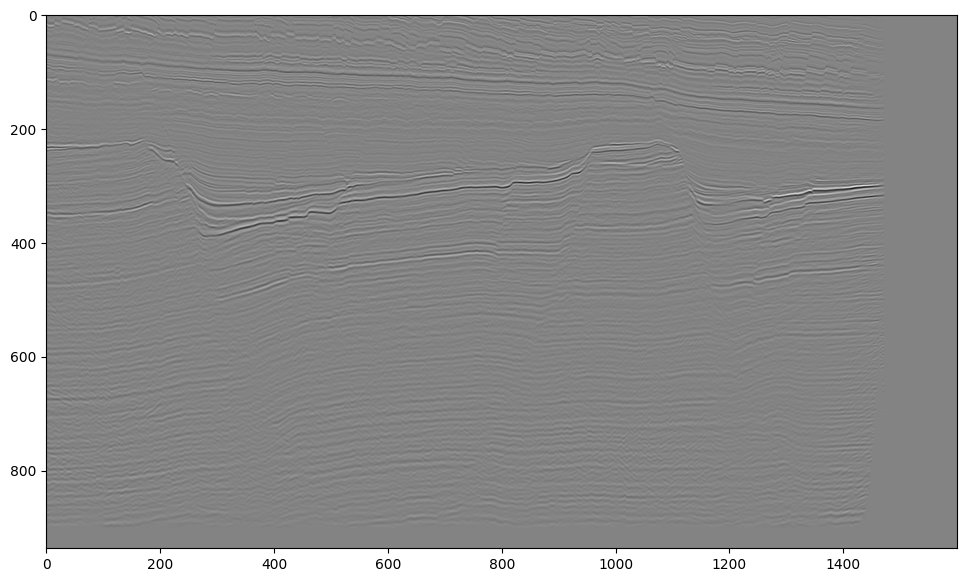

In [4]:
data = np.load("seistrain4.npz")['arr_0']
min_data_value = np.min(data)
max_data_value = np.max(data)
data = (data - min_data_value) / (max_data_value - min_data_value) * 255
data = data[10].T[600:, 400: 2000]
print(type(data))
print(data.dtype)
print(np.shape(data))
fig, ax = plt.subplots()
ax.imshow(data, cmap='gray_r')

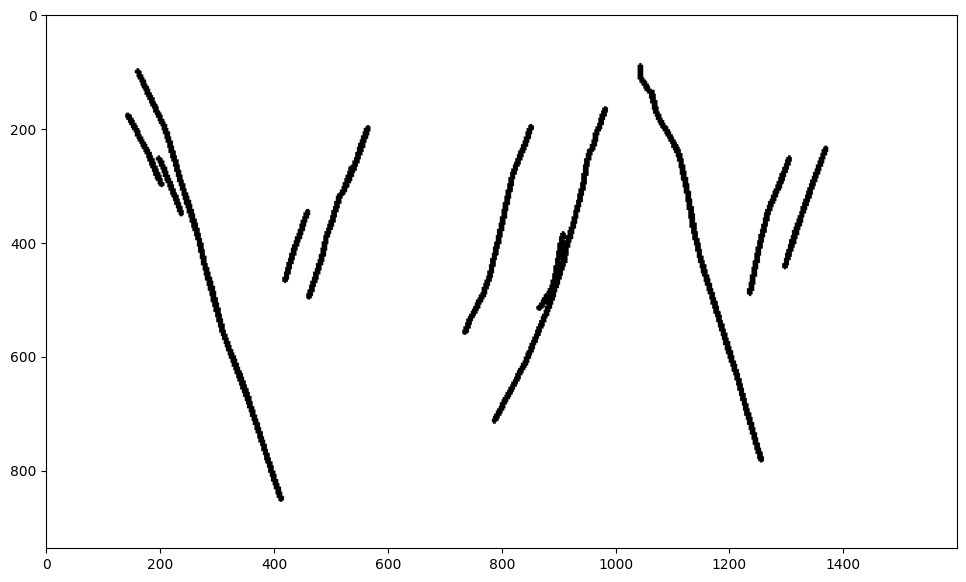

In [5]:
labels = np.load('faulttrain4.npz')['arr_0'][10].T[600:, 400: 2000]
fig, ax = plt.subplots()
ax.imshow(labels, cmap='gray_r')

In [6]:
def get_windows_coords(window_size, figure_size, stride):
    start_coord = 0
    coords_list = []
    while True:
        cur_start_coord = start_coord
        cur_end_coord = cur_start_coord + window_size
        if cur_end_coord > figure_size:
            cur_start_coord -= cur_end_coord - figure_size
            cur_end_coord = cur_start_coord + window_size
        coords_list.append([cur_start_coord, cur_end_coord])
        start_coord += stride
        if cur_end_coord == figure_size:
            return coords_list

WINDOW_SIZE = 256
STRIDE = 16

width_coords = get_windows_coords(window_size=WINDOW_SIZE, figure_size=np.shape(data)[1], stride=STRIDE)
height_coords = get_windows_coords(window_size=WINDOW_SIZE, figure_size=np.shape(data)[0], stride=STRIDE)
print(np.shape(data[height_coords[-1][0]: height_coords[-1][1], width_coords[-1][0]: width_coords[-1][1]]))

(256, 256)


In [7]:
THRESHOLD = 0.5
weights_path = 'data/weights/Latest_100epochs_1e-3lr.pth.gz'

predict_array = np.zeros(np.shape(data))
votes_array = np.zeros(np.shape(data))
# подгрузка модели нейросети
model = Unet()
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

iterations = 0
total_iterations = len(width_coords) * len(height_coords)
start_time = time.time()
for width in width_coords:
    for height in height_coords:
        img_window = ImageOps.grayscale(Image.fromarray(data[height[0]: height[1], width[0]: width[1]]))
        window = transforms.ToTensor()(img_window)
        window = window[None, :]
        window.to(device)

        output = model(window)
        output = output.squeeze().data.cpu().numpy()

        output[output >= THRESHOLD] = 1
        output[output < THRESHOLD] = 0

        votes_array[height[0]: height[1], width[0]: width[1]] += 1
        for i in range(len(output)):
            for j in range(len(output[i])):
                predict_array[height[0] + i][width[0] + j] += output[i][j]

        iterations += 1
        if iterations % 100 == 0:
            print(f"{iterations} / {total_iterations}")

for i in range(len(predict_array)):
    for j in range(len(predict_array[i])):
        try:
            predict_array[i][j] = predict_array[i][j] / votes_array[i][j]
        except ZeroDivisionError:
            print("ZeroDivisionError")
end_time = time.time()
print(end_time - start_time)

100 / 3740
200 / 3740
300 / 3740
400 / 3740
500 / 3740
600 / 3740
700 / 3740
800 / 3740
900 / 3740
1000 / 3740
1100 / 3740
1200 / 3740
1300 / 3740
1400 / 3740
1500 / 3740
1600 / 3740
1700 / 3740
1800 / 3740
1900 / 3740
2000 / 3740
2100 / 3740
2200 / 3740
2300 / 3740
2400 / 3740
2500 / 3740
2600 / 3740
2700 / 3740
2800 / 3740
2900 / 3740
3000 / 3740
3100 / 3740
3200 / 3740
3300 / 3740
3400 / 3740
3500 / 3740
3600 / 3740
3700 / 3740
1423.8330631256104


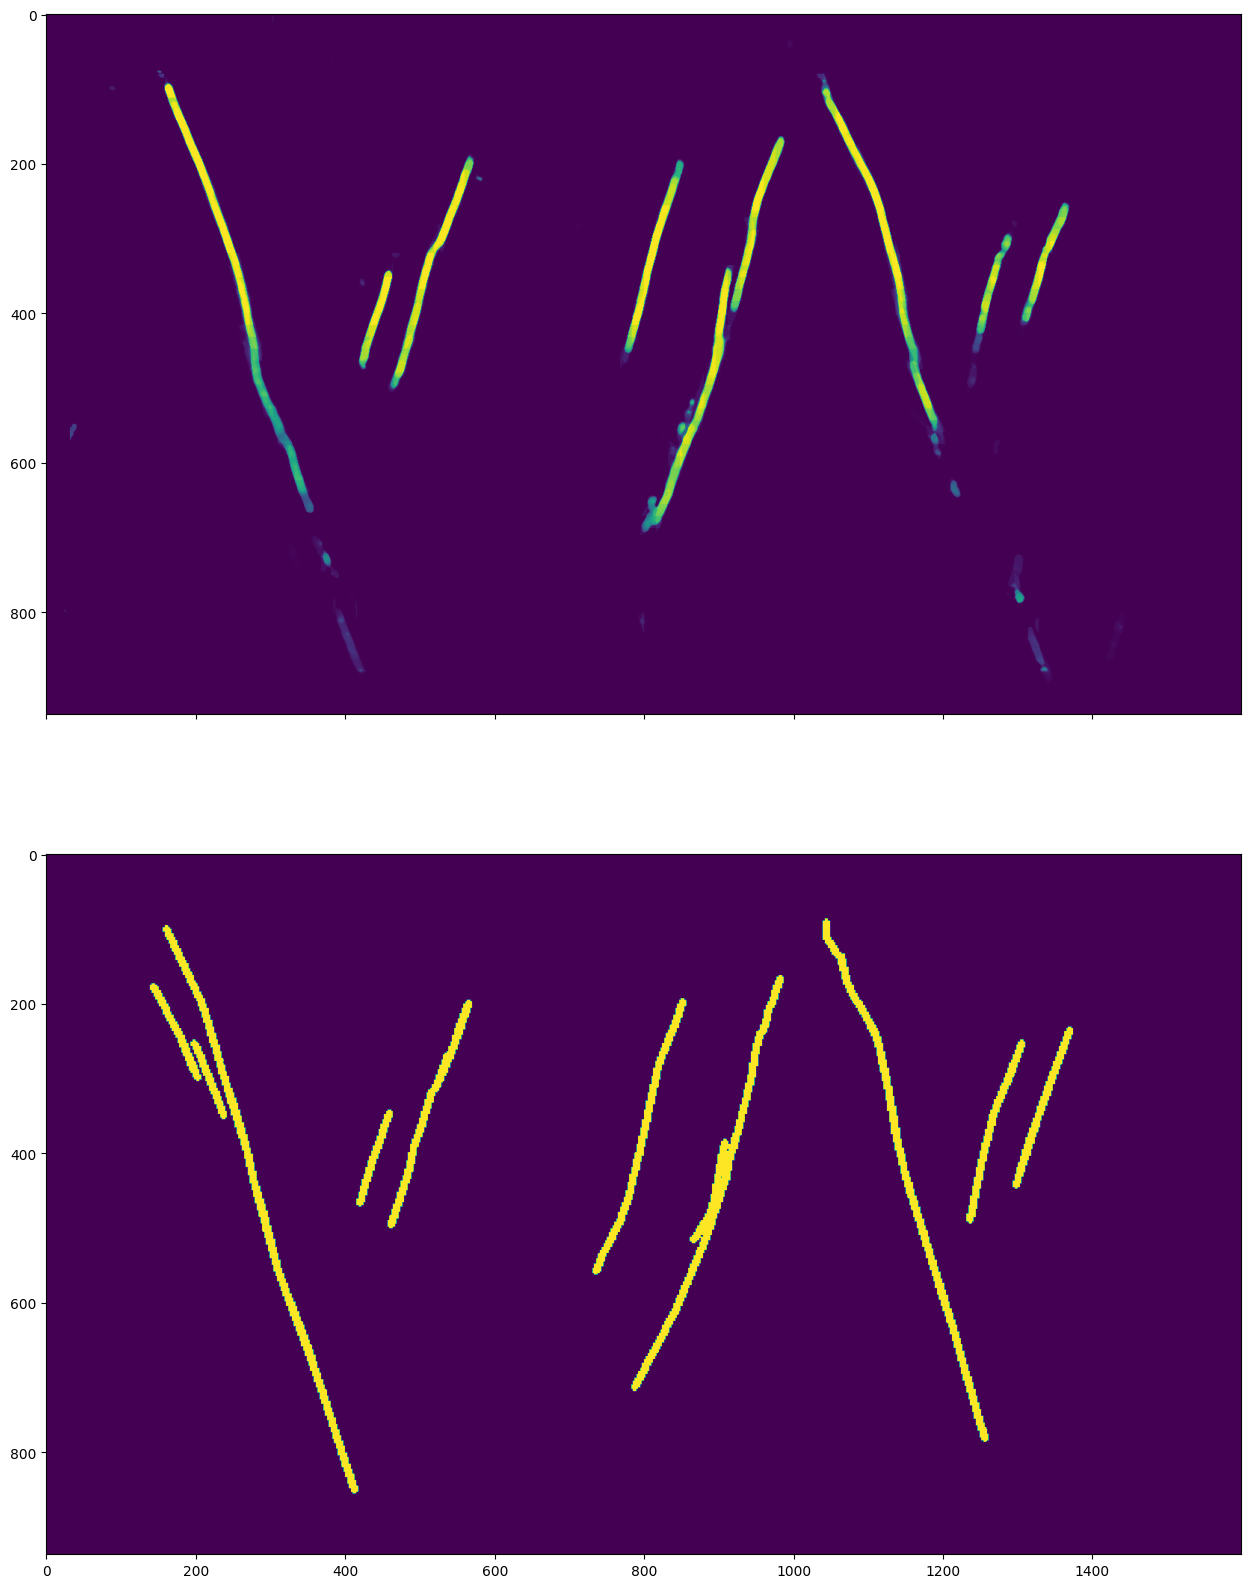

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 20))
ax[0].imshow(predict_array)
ax[1].imshow(labels);

## Предсказание единого изображения

In [ ]:
data = np.load("seistrain4.npz")['arr_0']
min_data_value = np.min(data)
max_data_value = np.max(data)
data = (data - min_data_value) / (max_data_value - min_data_value) * 255
# data = data[42].T[600:, 400: 2000]
data = data[10].T[600:, 400: 2015]
print(type(data))
print(data.dtype)
print(np.shape(data))
fig, ax = plt.subplots()
ax.imshow(data, cmap='gray_r')

In [ ]:
# labels = np.load('faulttrain4.npz')['arr_0'][42].T[600:, 400: 2000]
labels = np.load('faulttrain4.npz')['arr_0'][10].T[600:, 400: 2015]
fig, ax = plt.subplots()
ax.imshow(labels, cmap='gray_r')

In [ ]:
print(labels[:,:].shape)

In [ ]:
# print(data.shape)
# n_rows_to_add = data.shape[1] - data.shape[0]
# for i in range(n_rows_to_add):
#     data = np.r_[data,[np.zeros(data.shape[1])]]
# print(data.shape)
# print(labels.shape)
# n_rows_to_add = labels.shape[1] - labels.shape[0]
# for i in range(n_rows_to_add):
#     labels = np.r_[labels,[np.zeros(labels.shape[1])]]
# print(labels.shape)

def pad_data(data, divisor=16):
    shape_y, shape_x = data.shape
    padding = [0, 0]
    if shape_x % divisor != 0:
        for i in range(divisor):
            if data.shape[1] % divisor == 0:
                break
            data = np.c_[data,np.zeros(data.shape[0])]
        padding[0] = i
    if shape_y % divisor != 0:
        for i in range(divisor):
            if data.shape[0] % divisor == 0:
                break
            data = np.r_[data,[np.zeros(data.shape[1])]]
        padding[1] = i
    return data, padding
data, data_padding = pad_data(data)
labels, labels_padding = pad_data(labels)
print(data.shape)
print(labels.shape)
print(data_padding)
# print(data.shape)
# if data.shape[0] % 2 == 1:
#     data = np.r_[data,[np.zeros(data.shape[1])]]
#     labels = np.r_[data,[np.zeros(labels.shape[1])]]
# print(data.shape)

In [ ]:
THRESHOLD = 0.5
weights_path = 'data/weights/Latest_100epochs_1e-3lr.pth.gz'

# подгрузка модели нейросети
model = Unet()
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

start_time = time.time()
img_window = ImageOps.grayscale(Image.fromarray(data))
window = transforms.ToTensor()(img_window)
window = window[None, :]
window.to(device)

output = model(window)
output = output.squeeze().data.cpu().numpy()
print(output.shape)
if data_padding[1] != 0:
    output = output[:-data_padding[1], :]
if data_padding[0] != 0:
    output = output[:, :-data_padding[0]]
# output = output[:-data_padding[1],:-data_padding[0]]
print(output.shape)

output[output >= THRESHOLD] = 1
output[output < THRESHOLD] = 0

end_time = time.time()
print(end_time - start_time)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 20))
ax[0].imshow(output)
ax[1].imshow(labels);

## Предсказание множества горизонтов

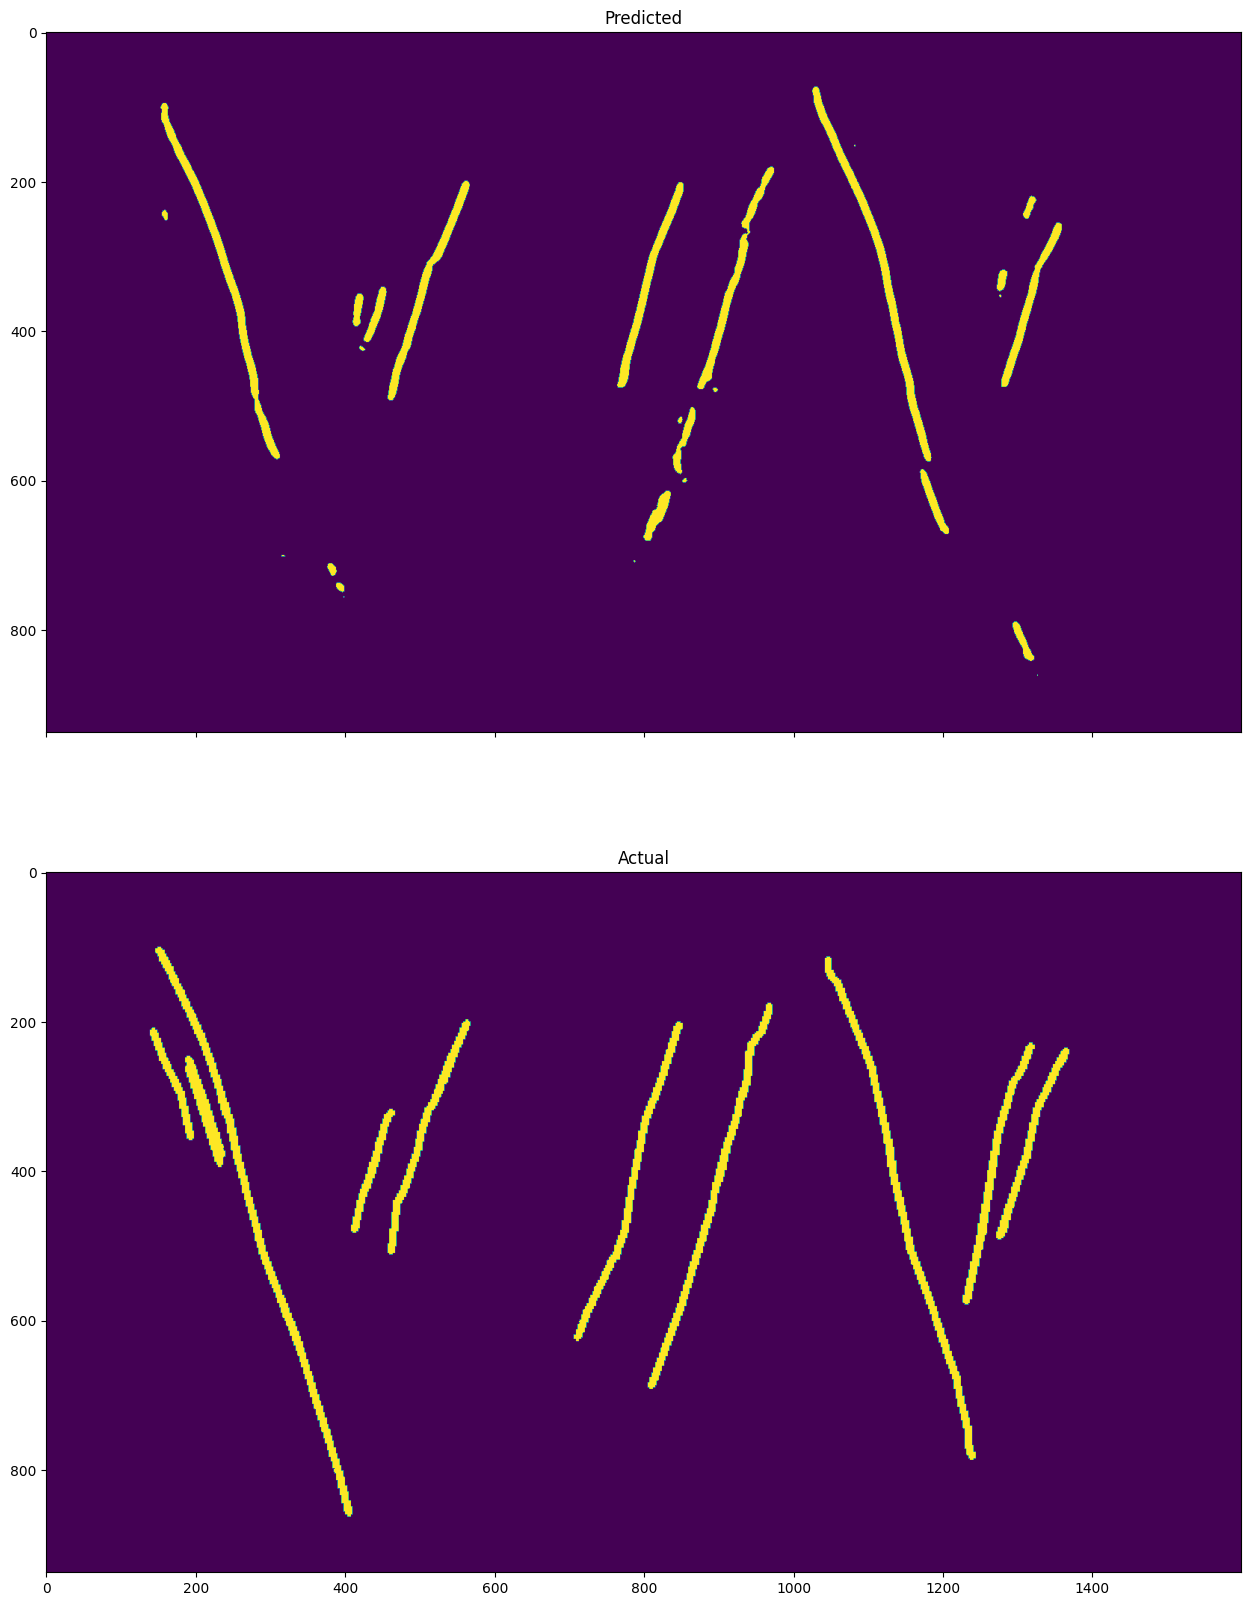

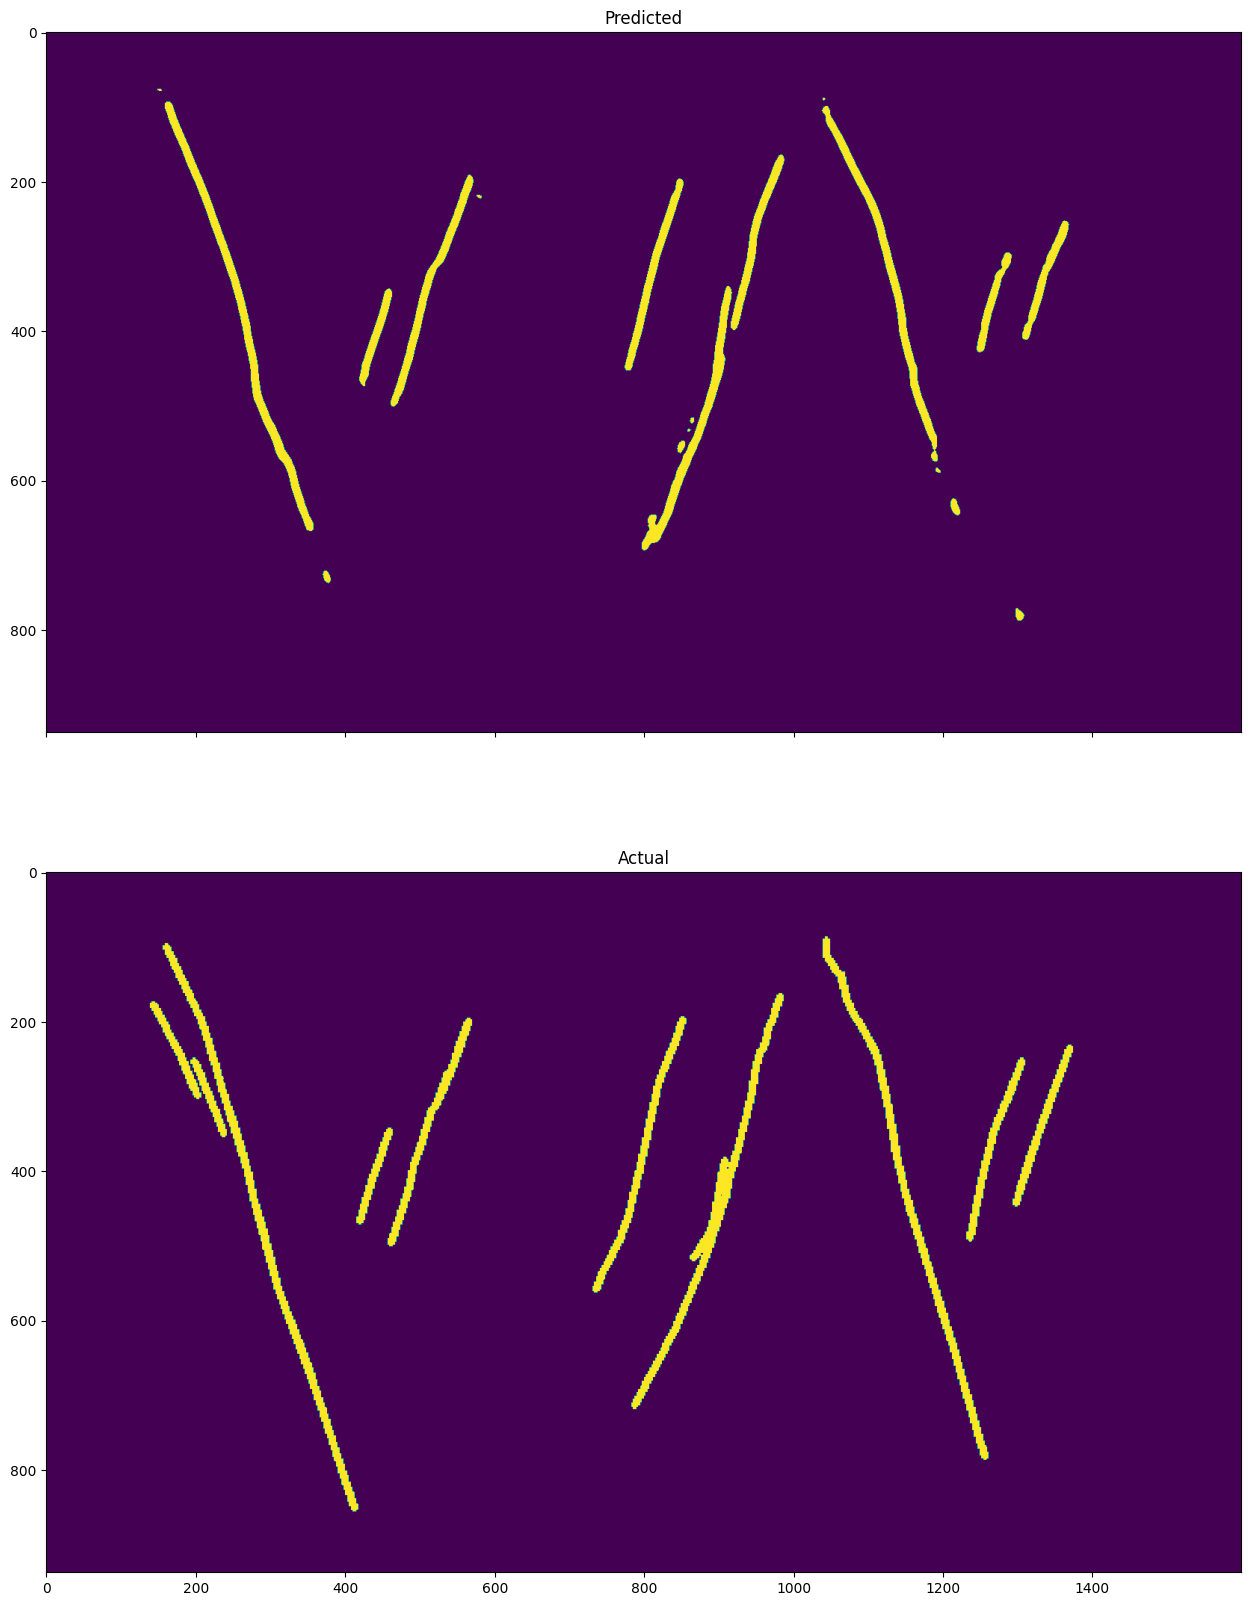

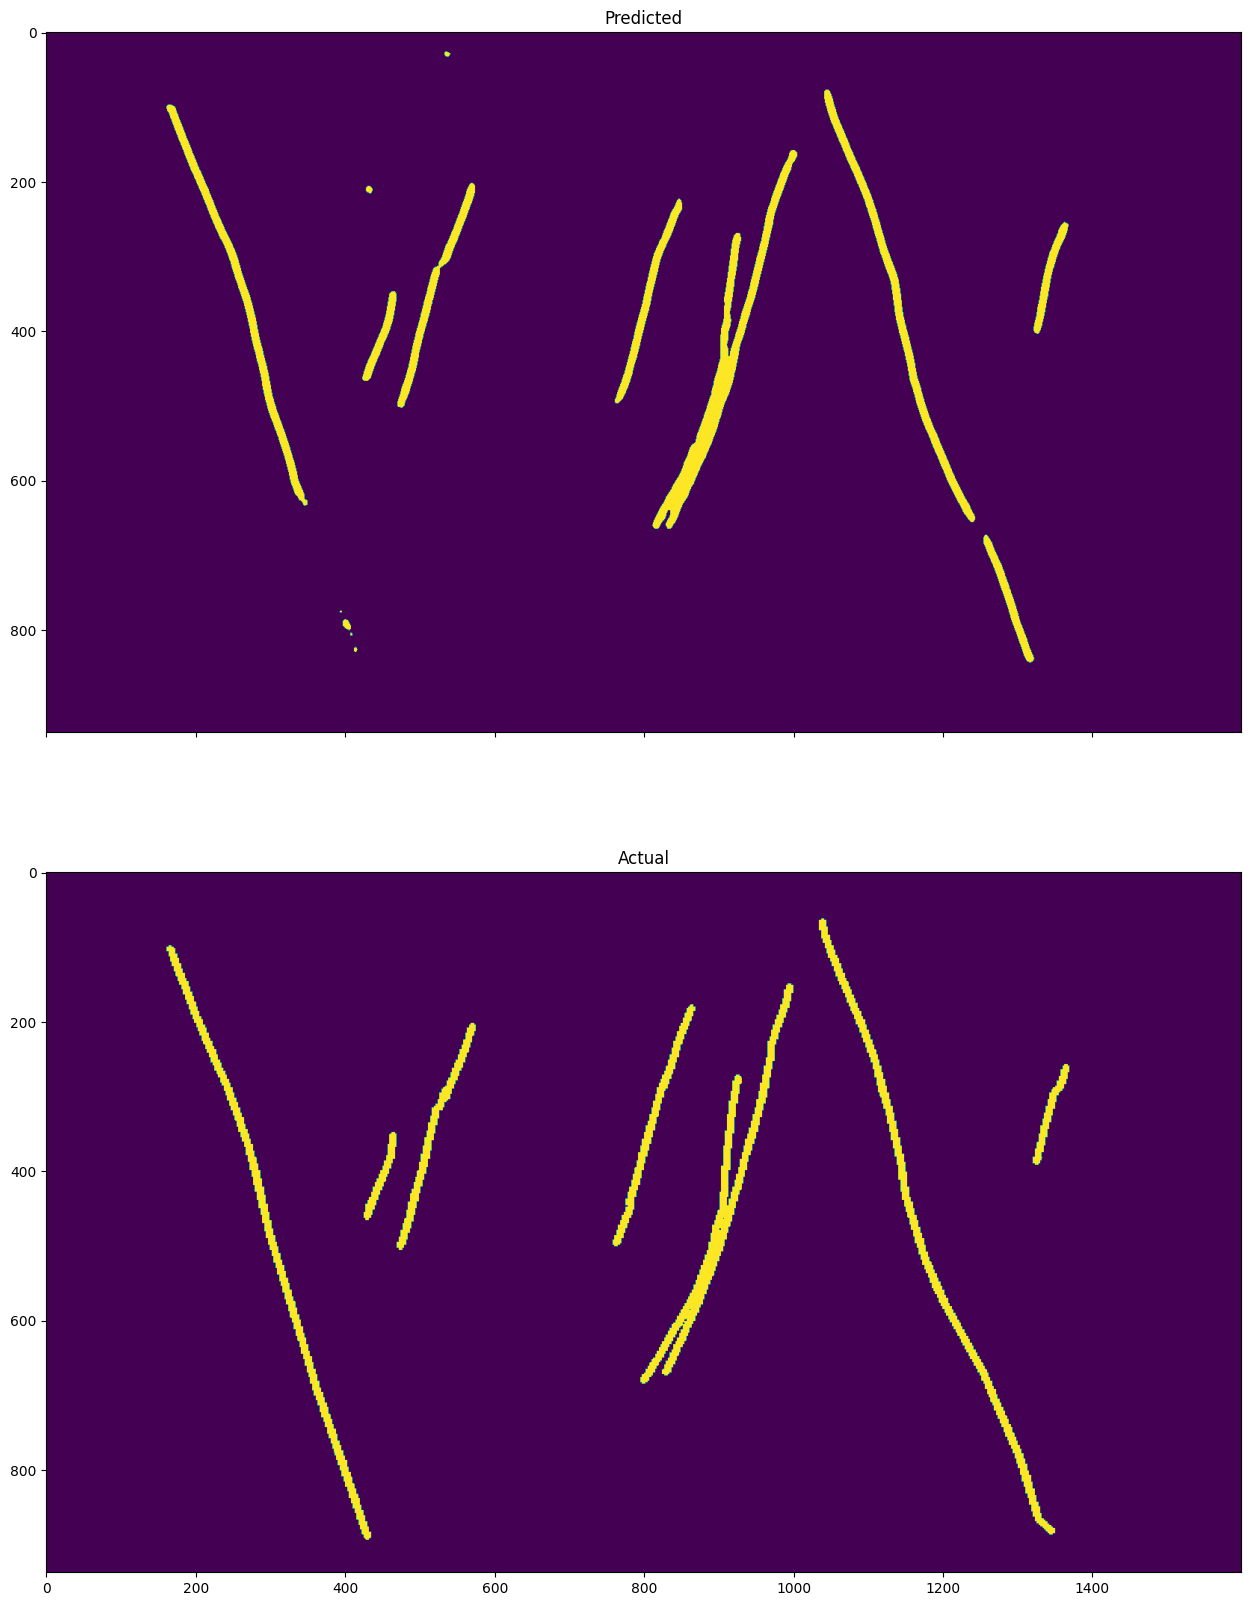

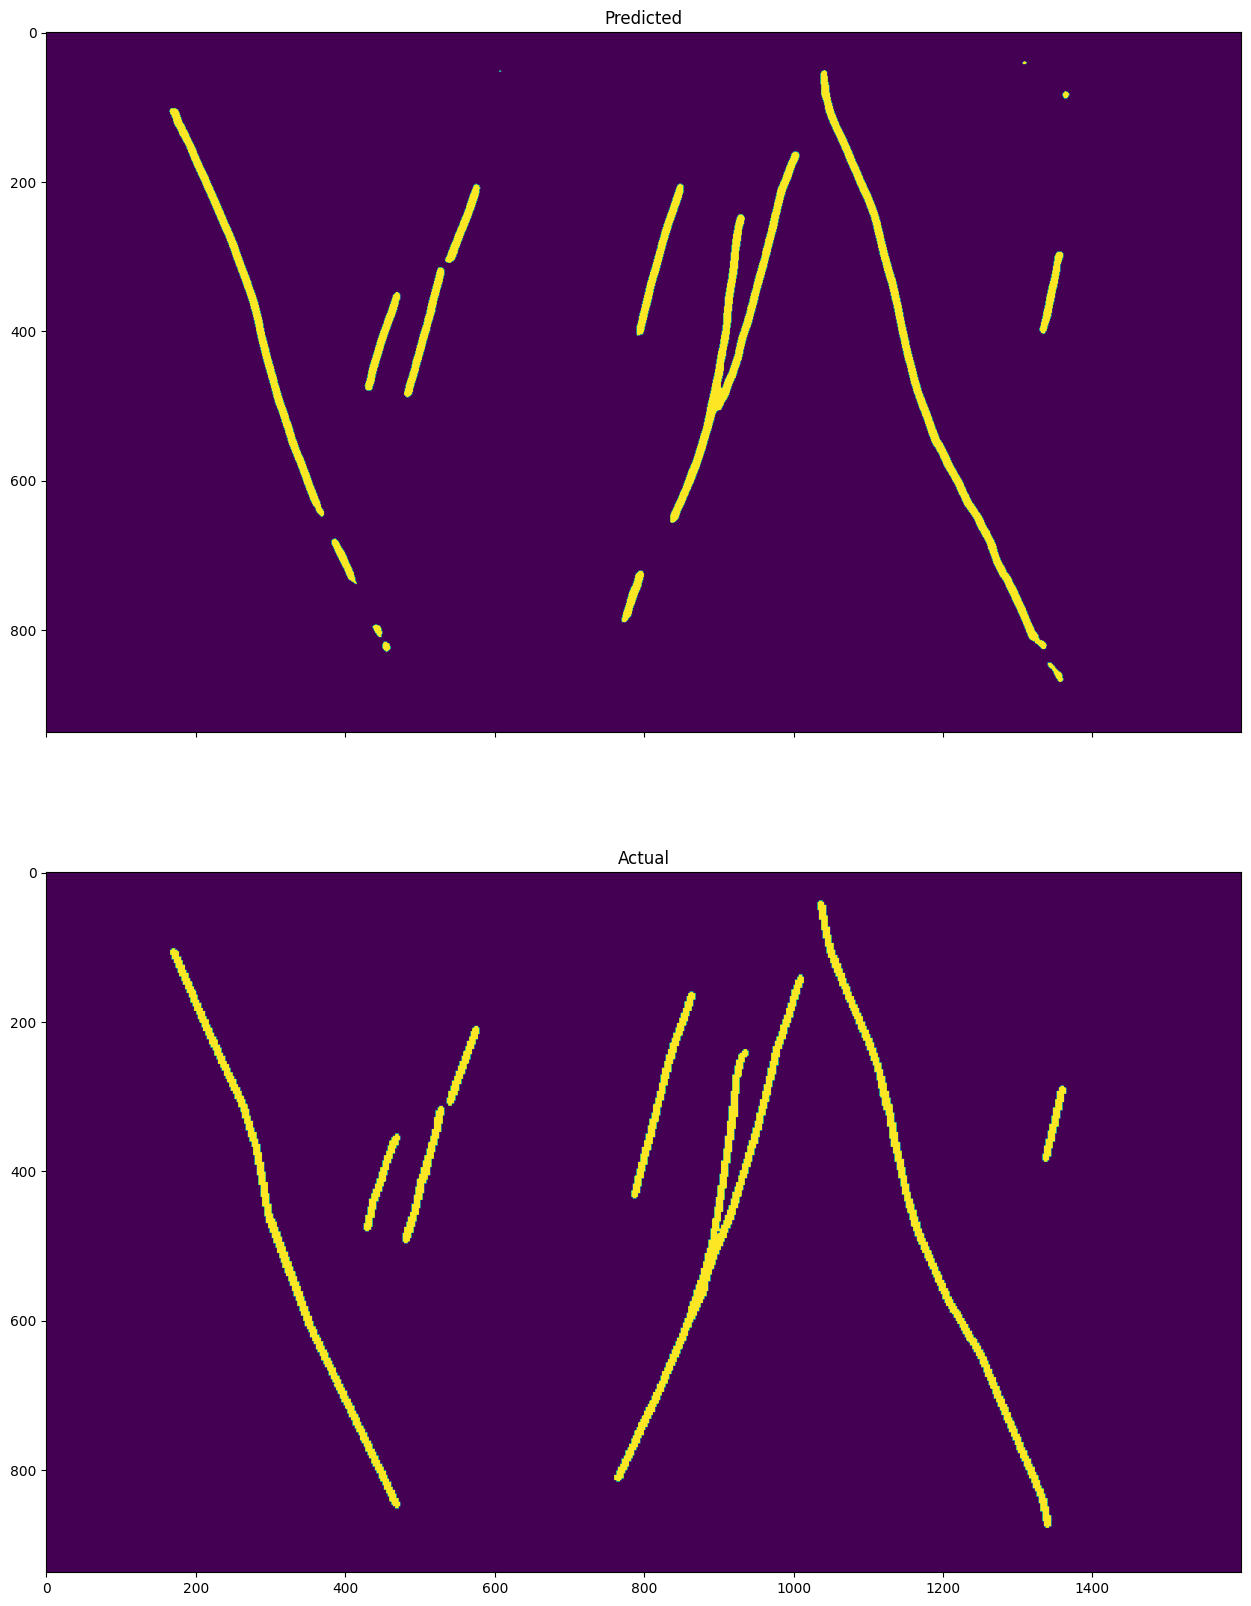

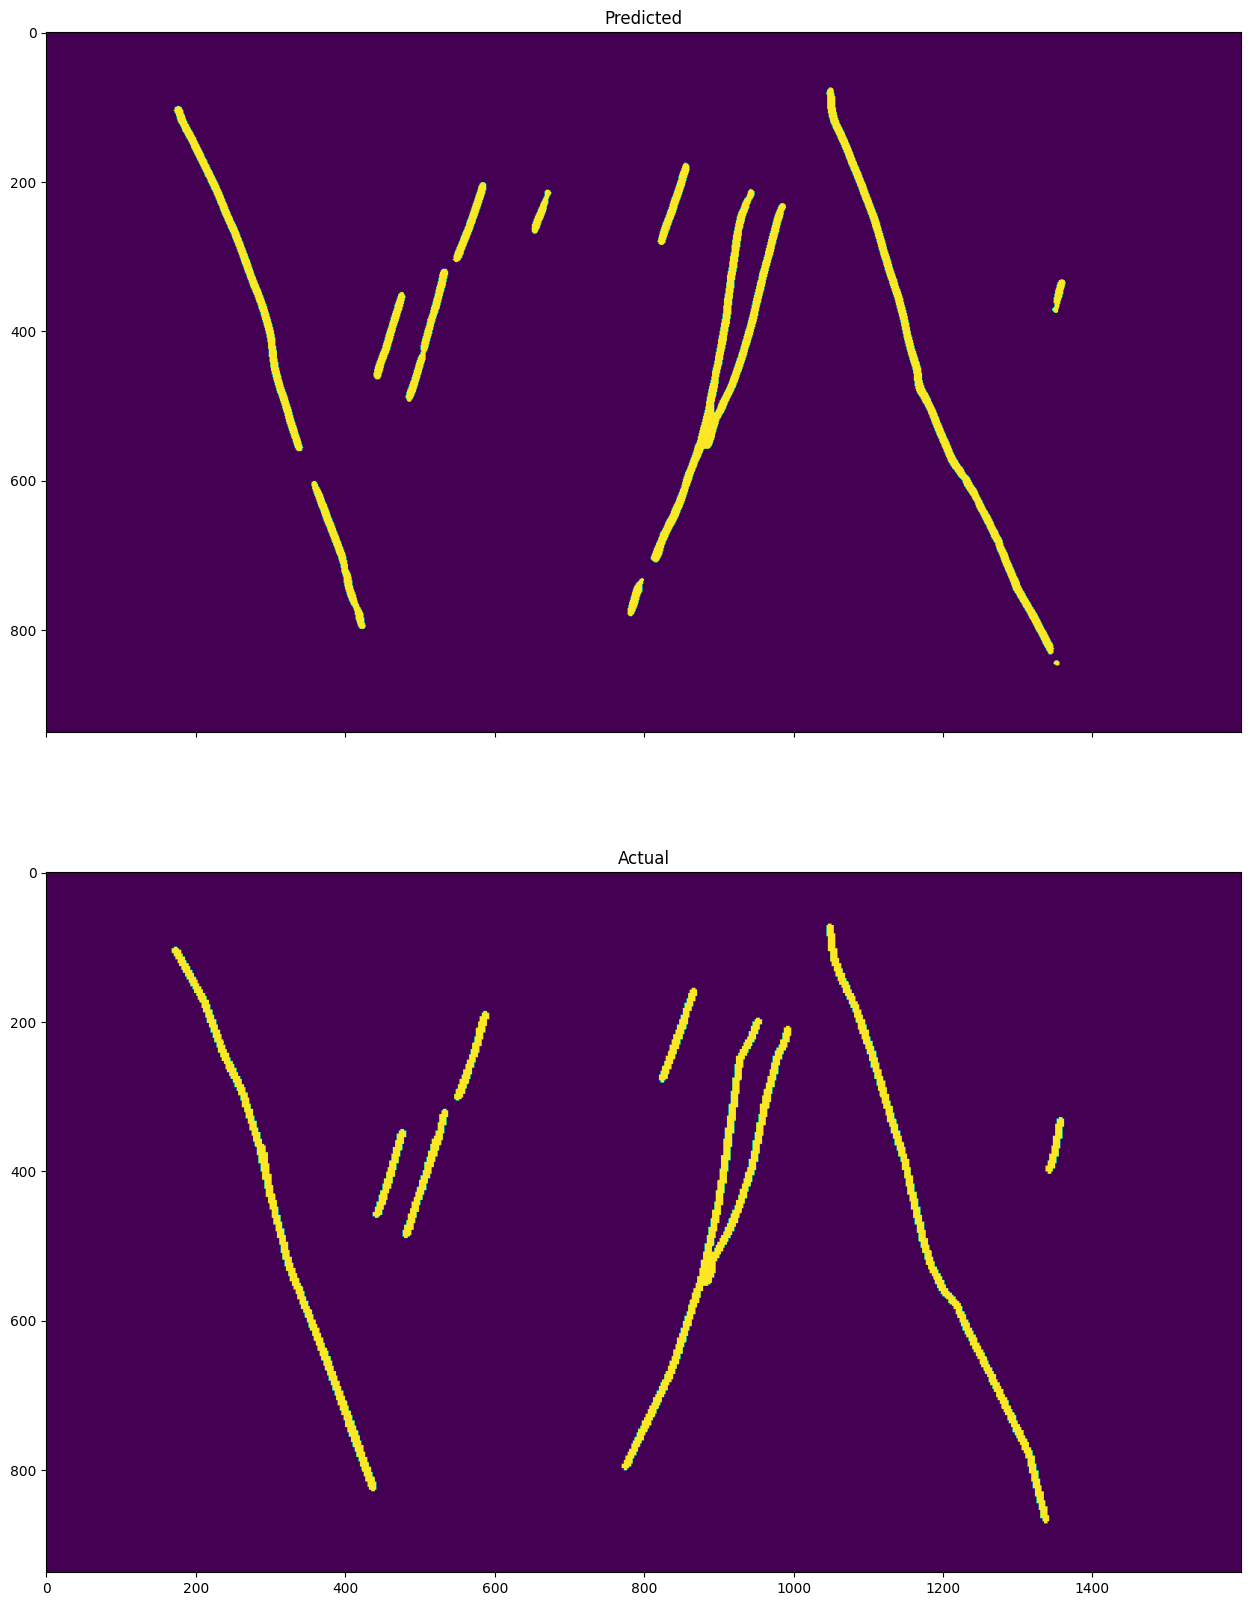

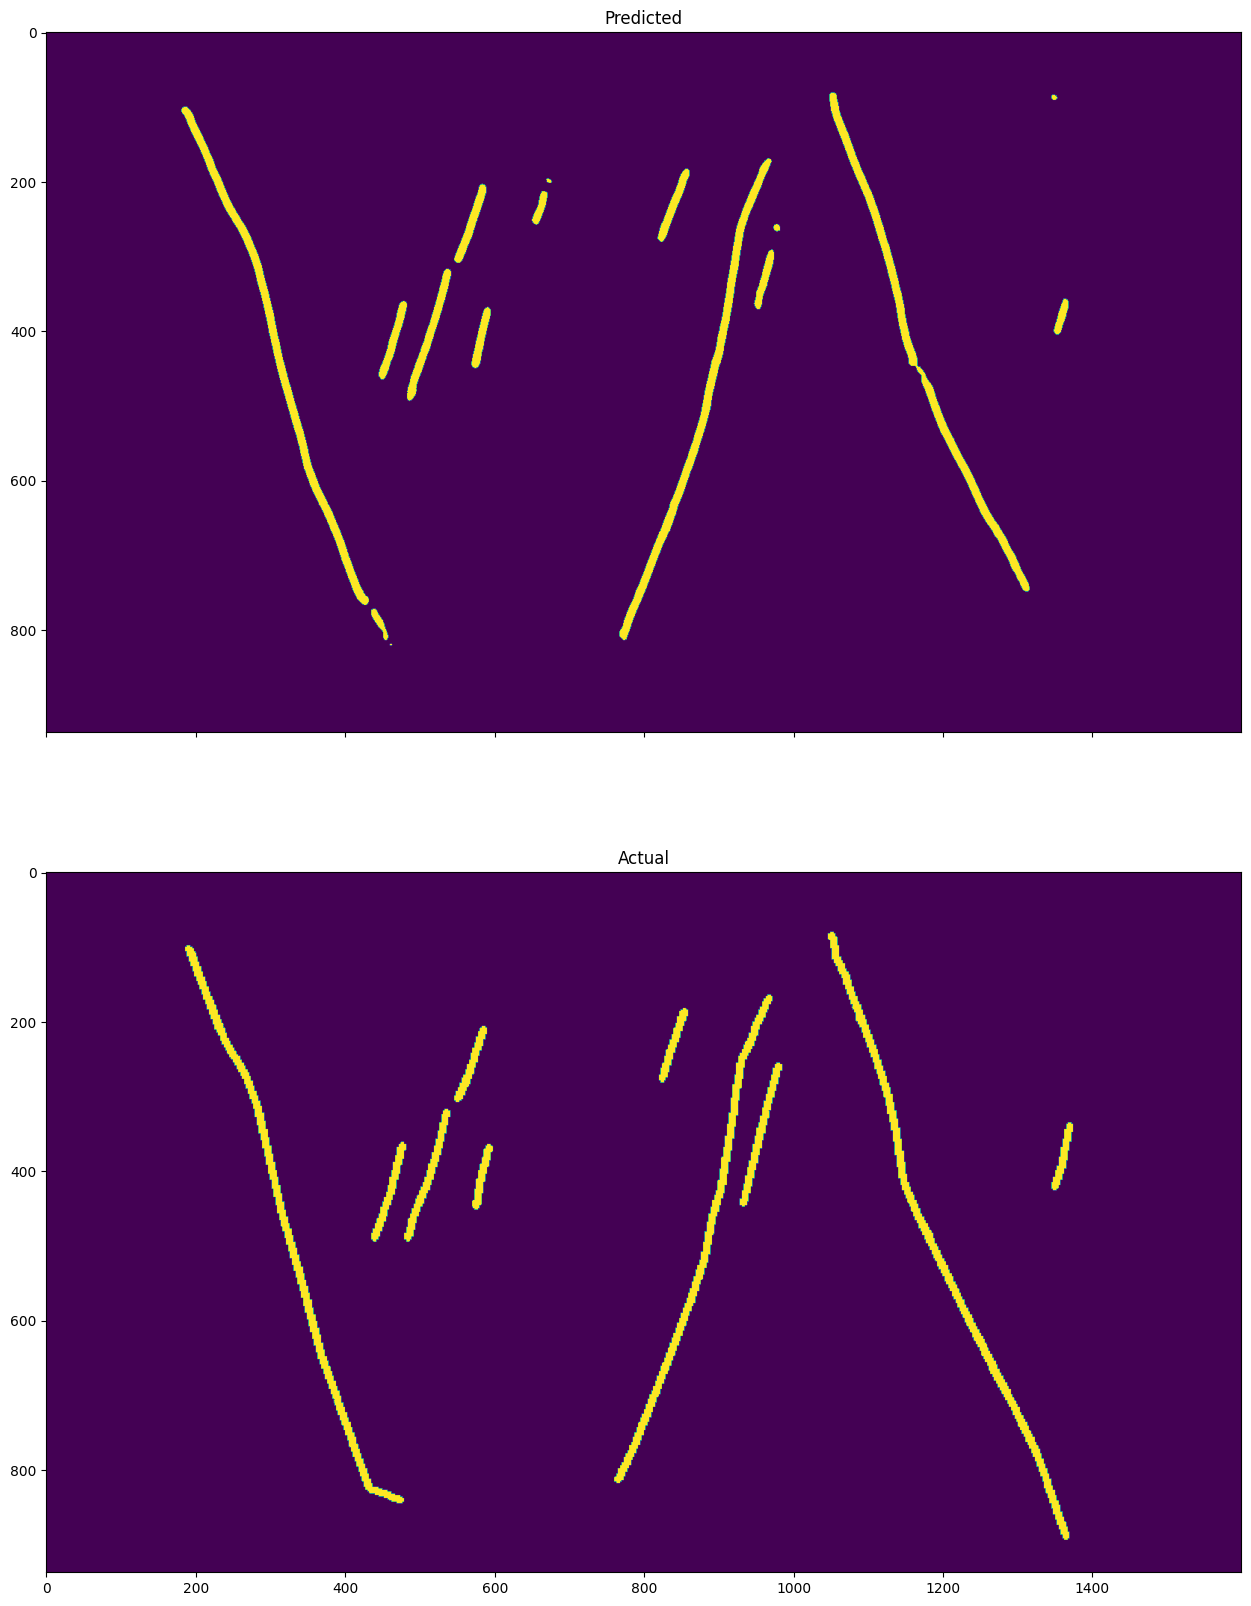

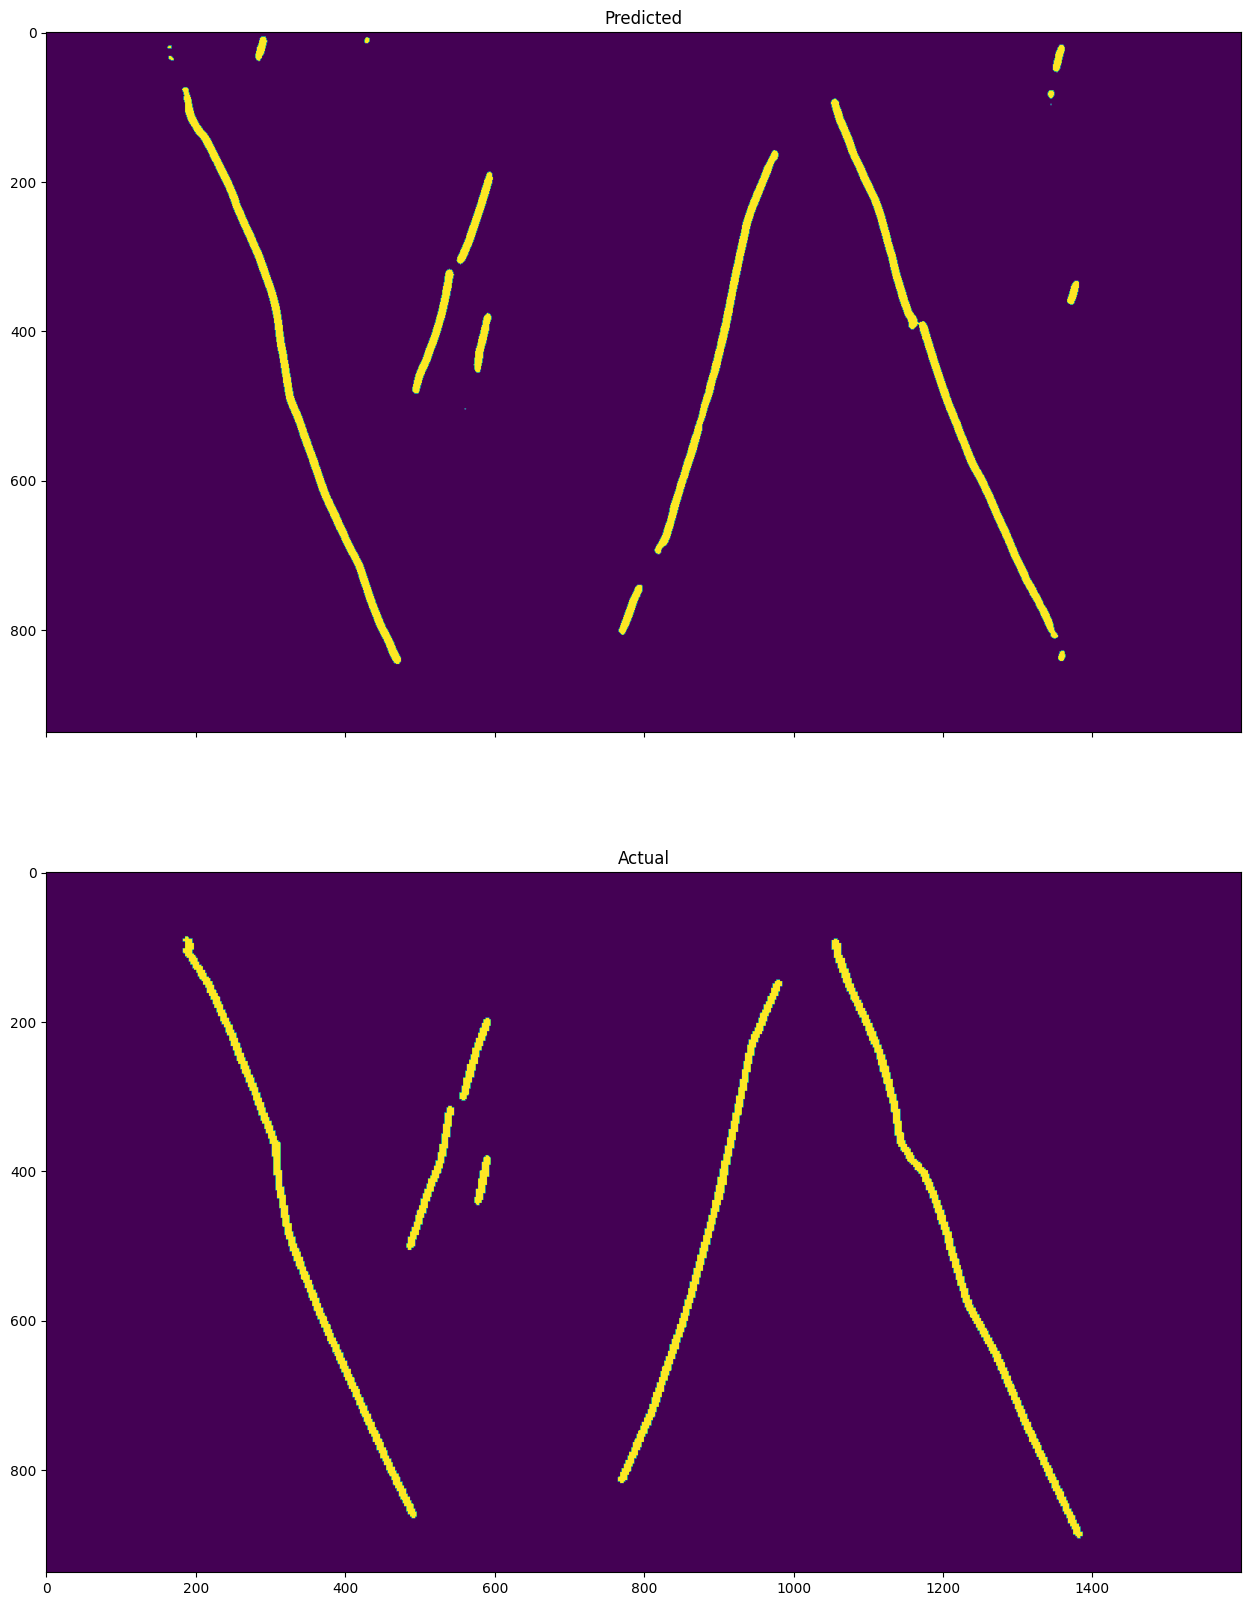

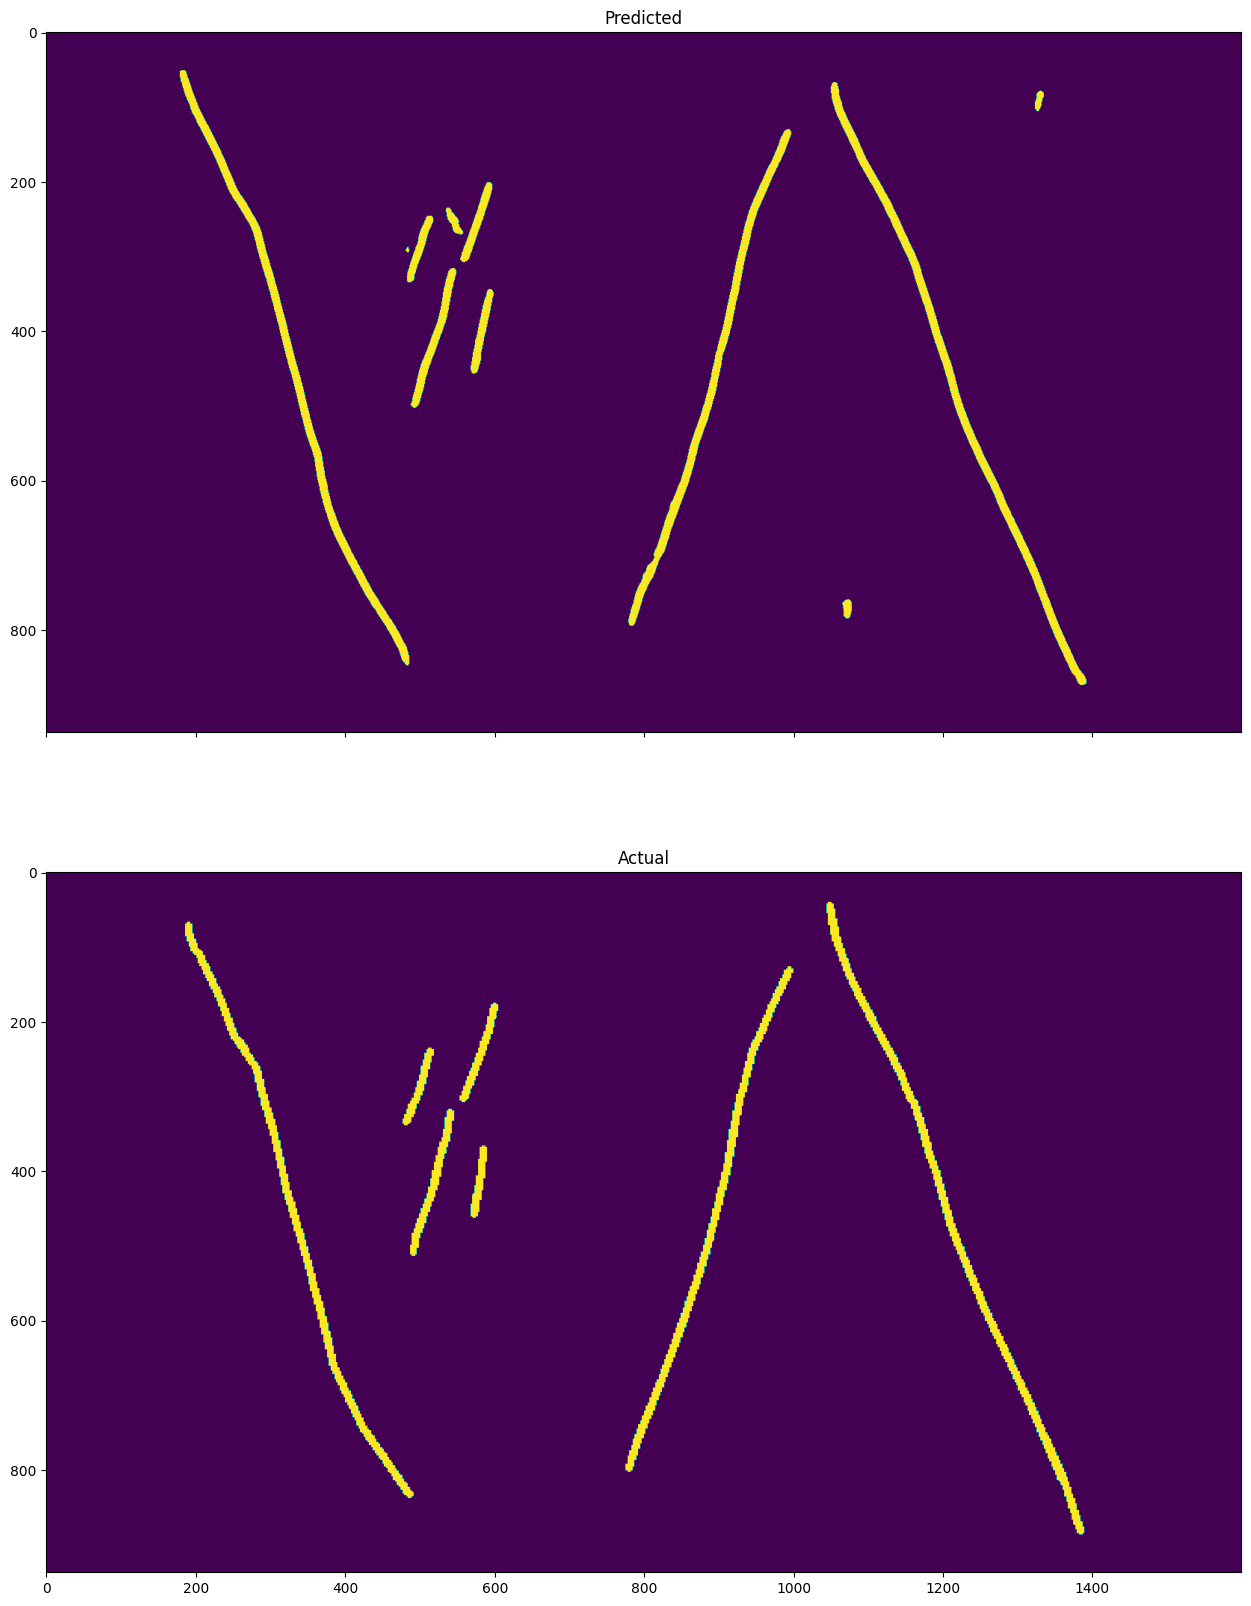

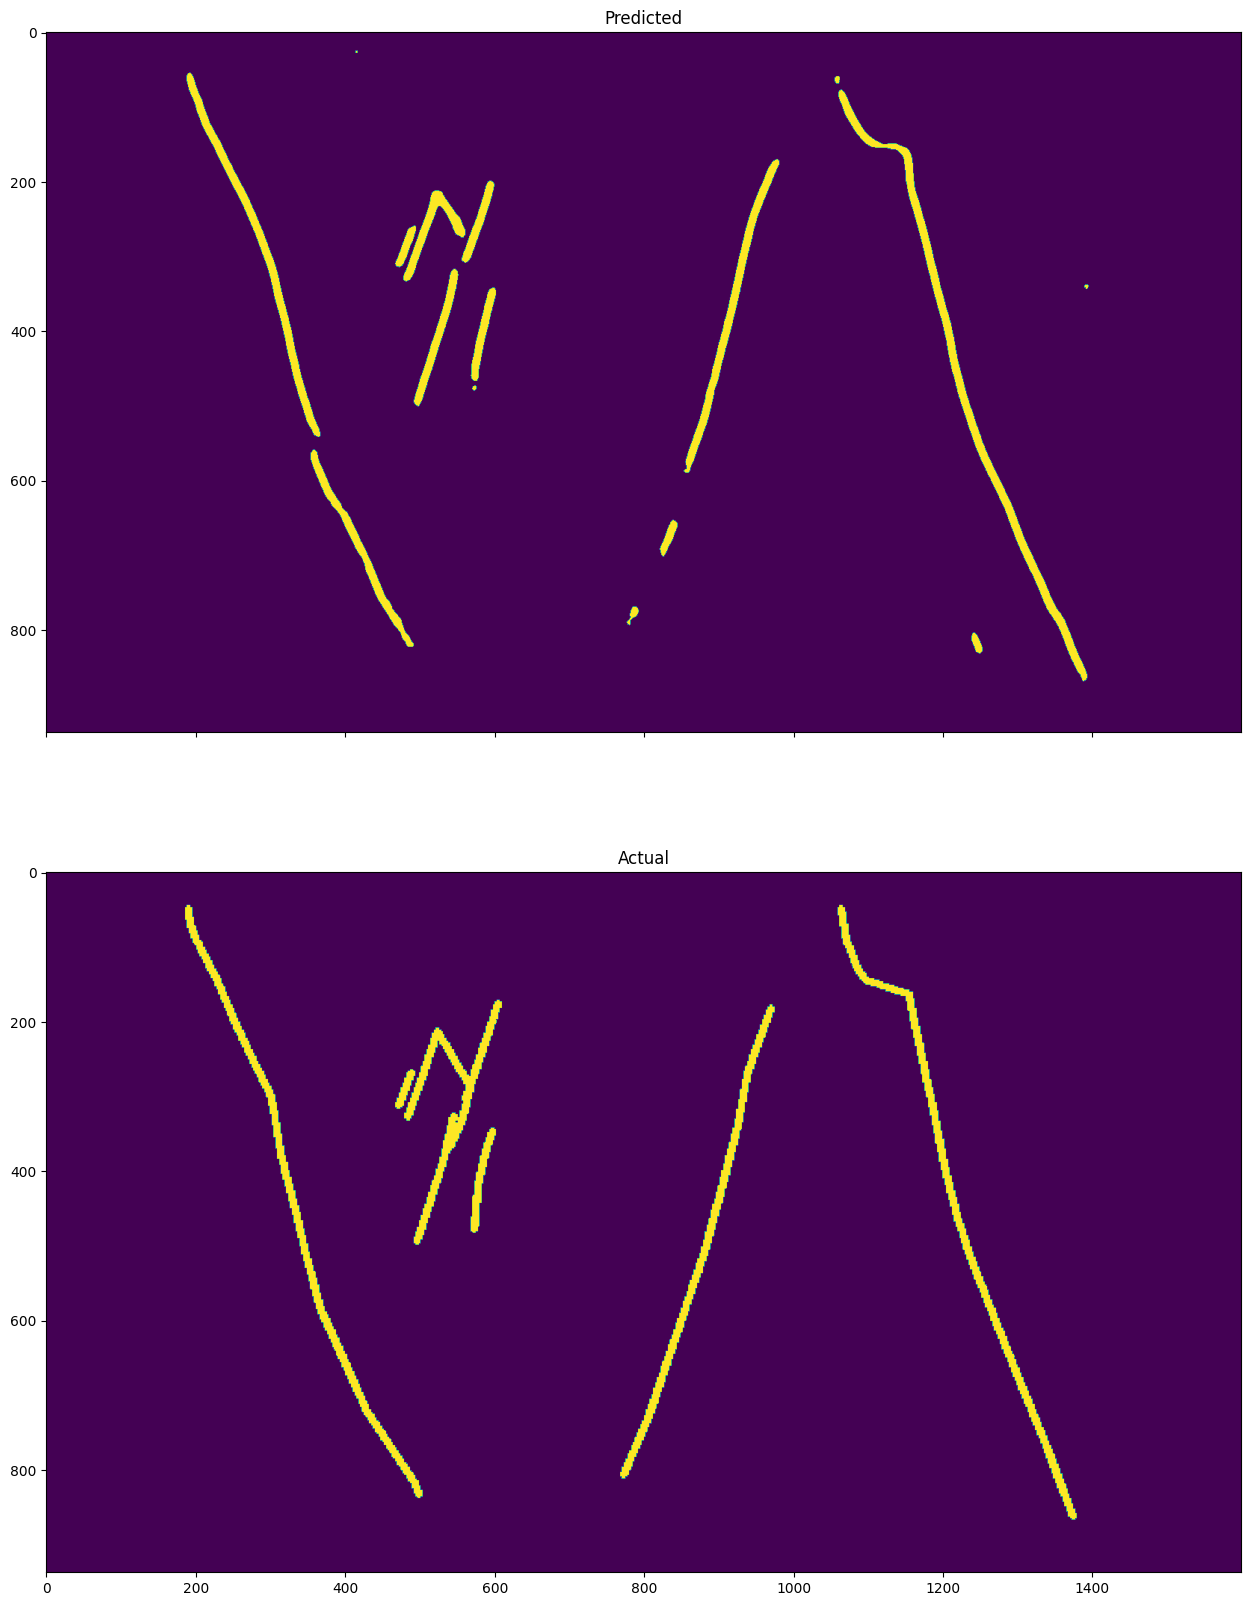

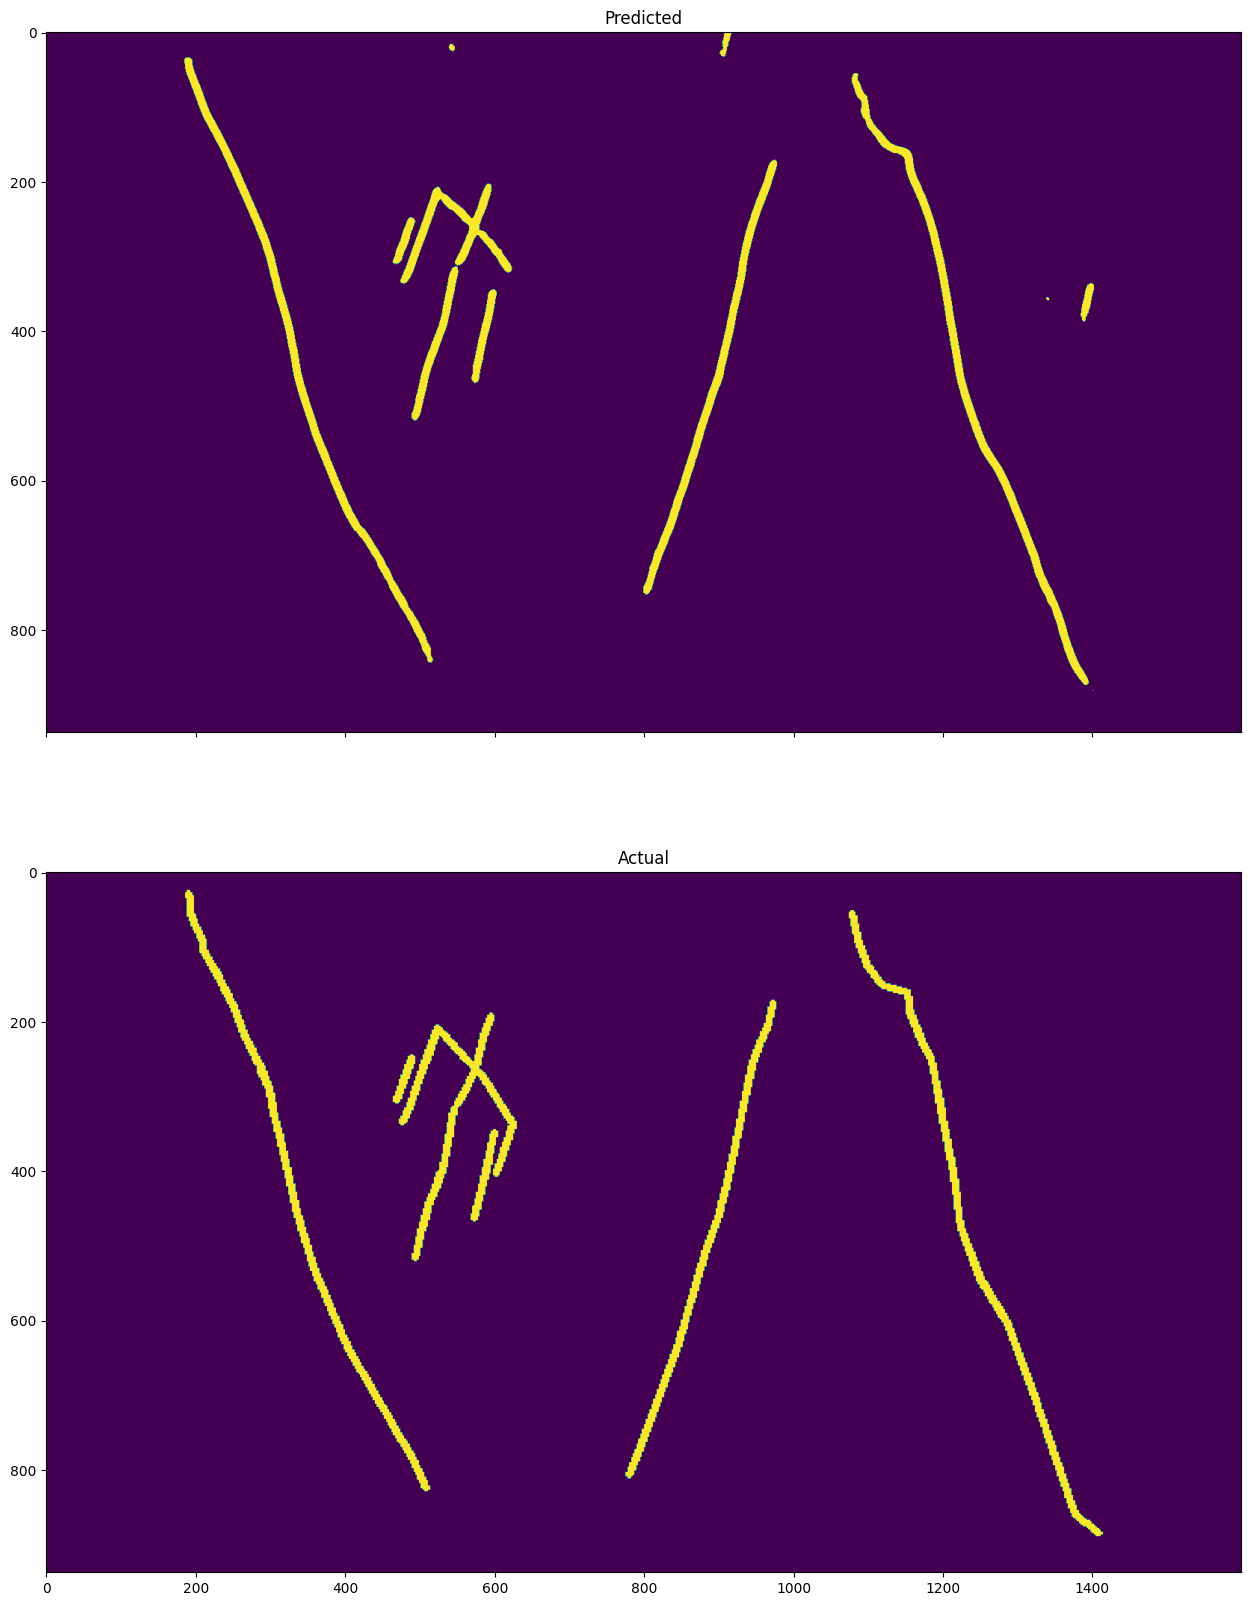

In [9]:
def pad_data(data, divisor=16):
    shape_y, shape_x = data.shape
    padding = [None, None]
    if shape_x % divisor != 0:
        for i in range(divisor):
            if data.shape[1] % divisor == 0:
                break
            data = np.c_[data,np.zeros(data.shape[0])]
        padding[0] = -i
    if shape_y % divisor != 0:
        for i in range(divisor):
            if data.shape[0] % divisor == 0:
                break
            data = np.r_[data,[np.zeros(data.shape[1])]]
        padding[1] = -i
    return data, padding


def predict_horizon(network, data_path: str, labels_path: str, horizon_nums, device, threshold: float, slicing: list, divisor: int):
    data = np.load(data_path)['arr_0'].T
    min_data_value = np.min(data)
    max_data_value = np.max(data)
    data = (data - min_data_value) / (max_data_value - min_data_value) * 255
    data = data[slicing[0]:slicing[1],slicing[2]:slicing[3]]

    labels = np.load(labels_path)['arr_0'].T
    labels = labels[slicing[0]:slicing[1],slicing[2]:slicing[3]]

    for horizon_num in horizon_nums:
        data_slice = data[:,:,horizon_num]
        labels_slice = labels[:,:,horizon_num]
        data_slice, data_padding = pad_data(data_slice, divisor)
        # fig, ax = plt.subplots()
        # ax.imshow(data_slice, cmap='gray_r')
        # fig, ax = plt.subplots()
        # ax.imshow(labels_slice, cmap='gray_r')

        img_horizon = ImageOps.grayscale(Image.fromarray(data_slice))
        horizon = transforms.ToTensor()(img_horizon)
        horizon = horizon[None, :]
        horizon.to(device)

        output = network(horizon)
        output = output.squeeze().data.cpu().numpy()
        output = output[:data_padding[1],:data_padding[0]]

        output[output >= threshold] = 1
        output[output < threshold] = 0

        fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 20))
        ax[0].set_title("Predicted")
        ax[0].imshow(output)
        ax[1].set_title("Actual")
        ax[1].imshow(labels_slice)


THRESHOLD = 0.5
weights_path = 'data/weights/Latest_100epochs_1e-3lr.pth.gz'

# подгрузка модели нейросети
model = Unet()
model.load_state_dict(torch.load(weights_path, map_location=device))
model.eval()

predict_horizon(model, "seistrain4.npz", "faulttrain4.npz", range(0, 100, 10), device, THRESHOLD, slicing=[600, None, 400, 2000], divisor=16)

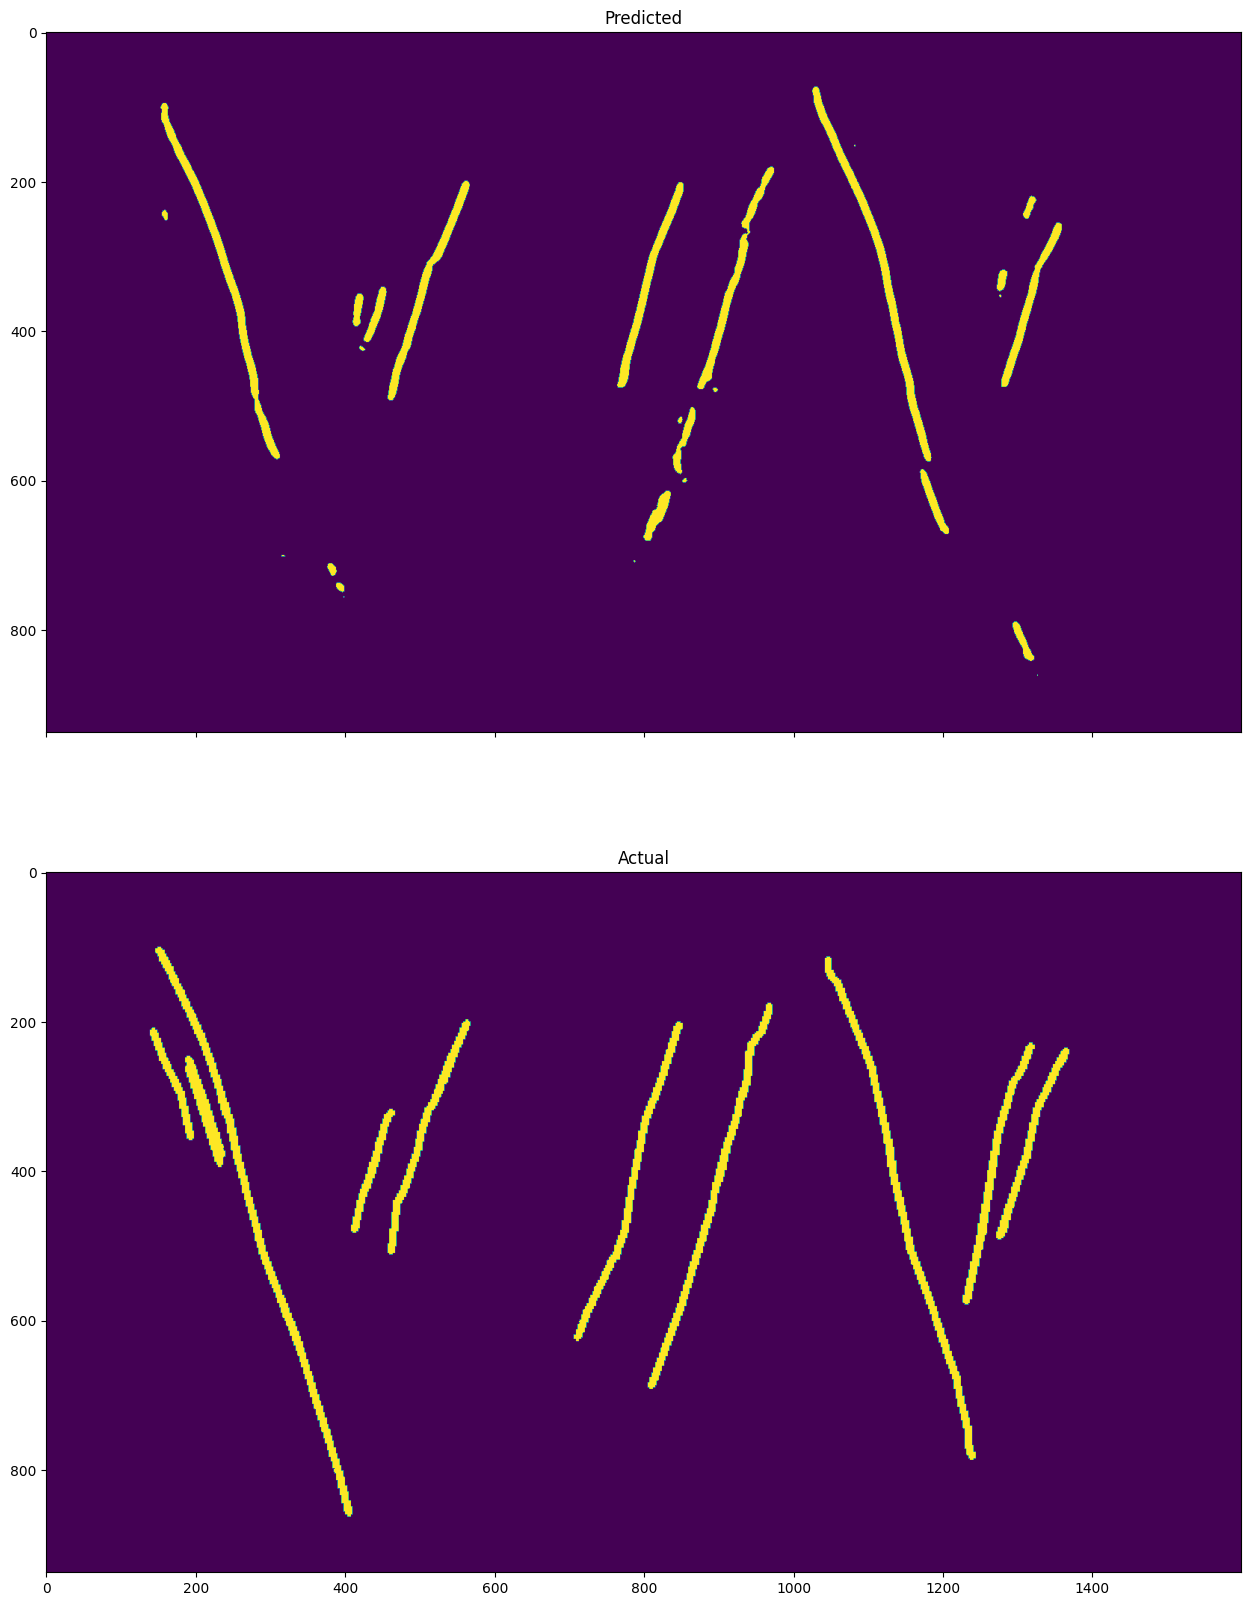

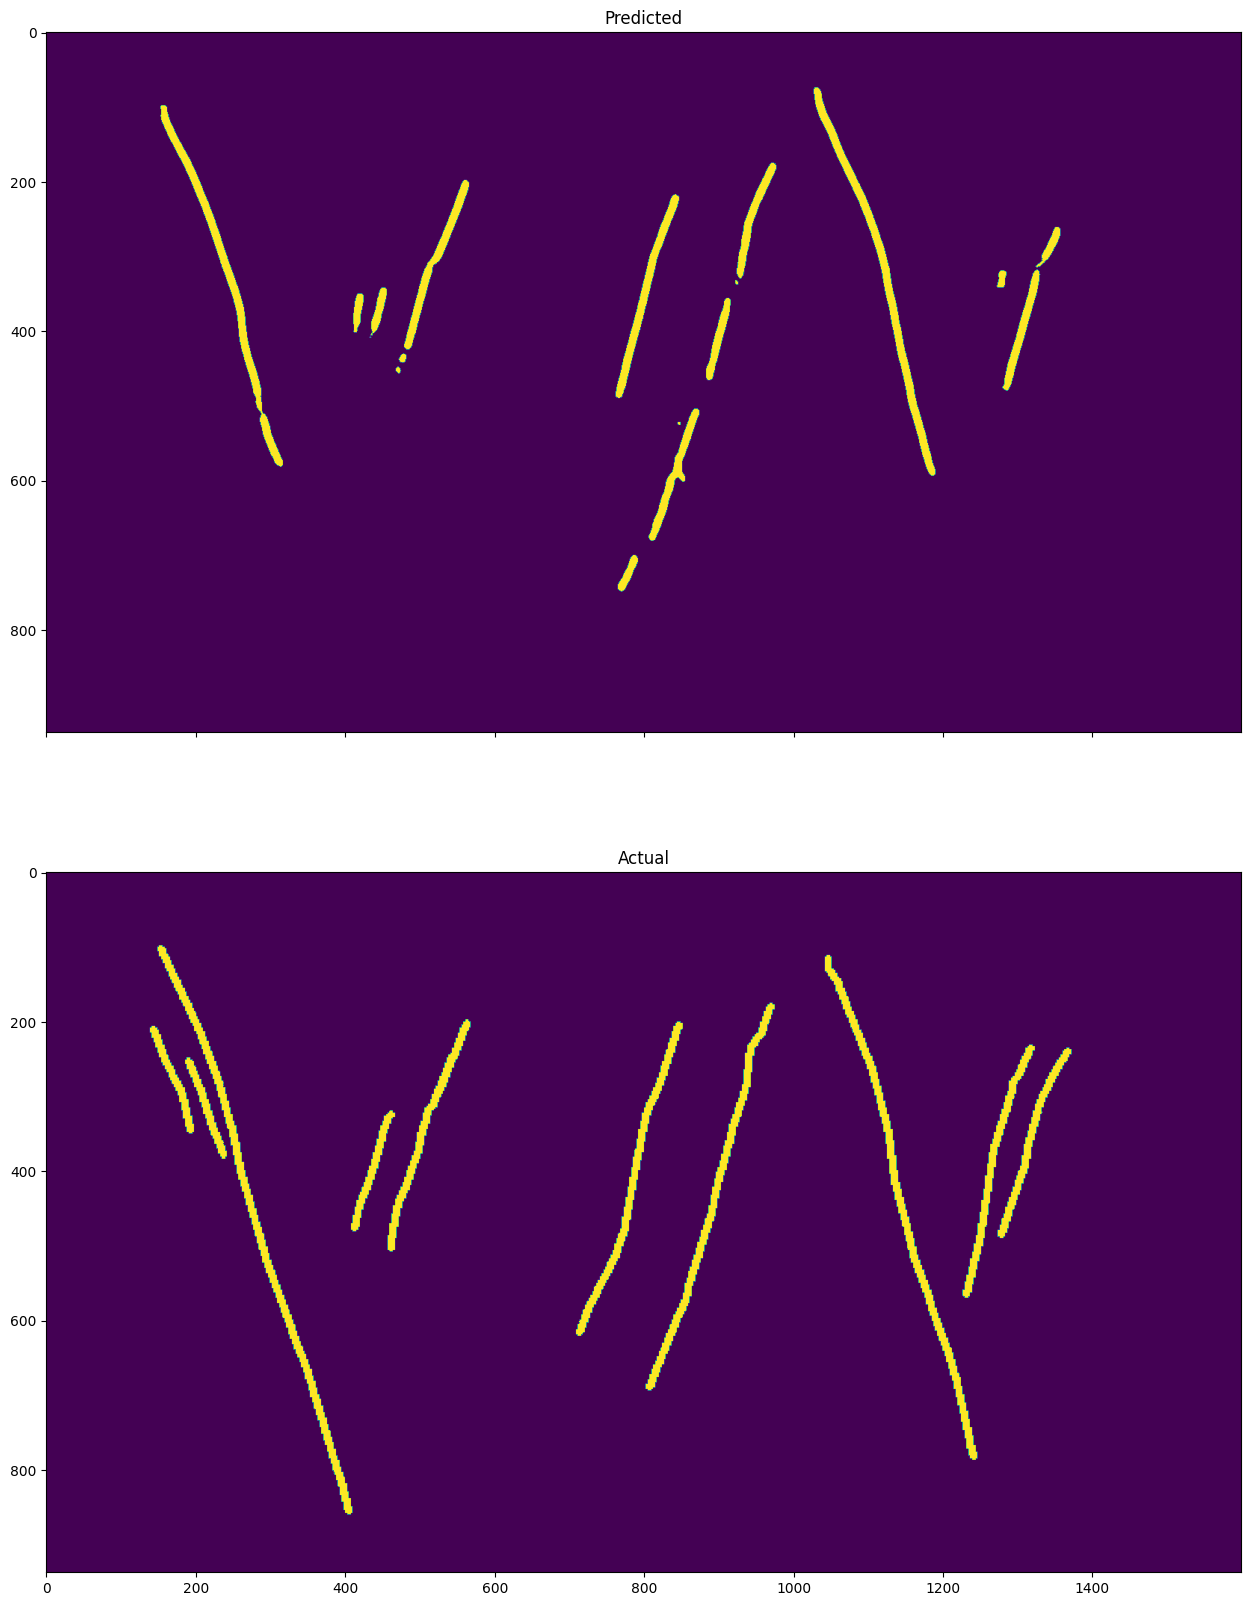

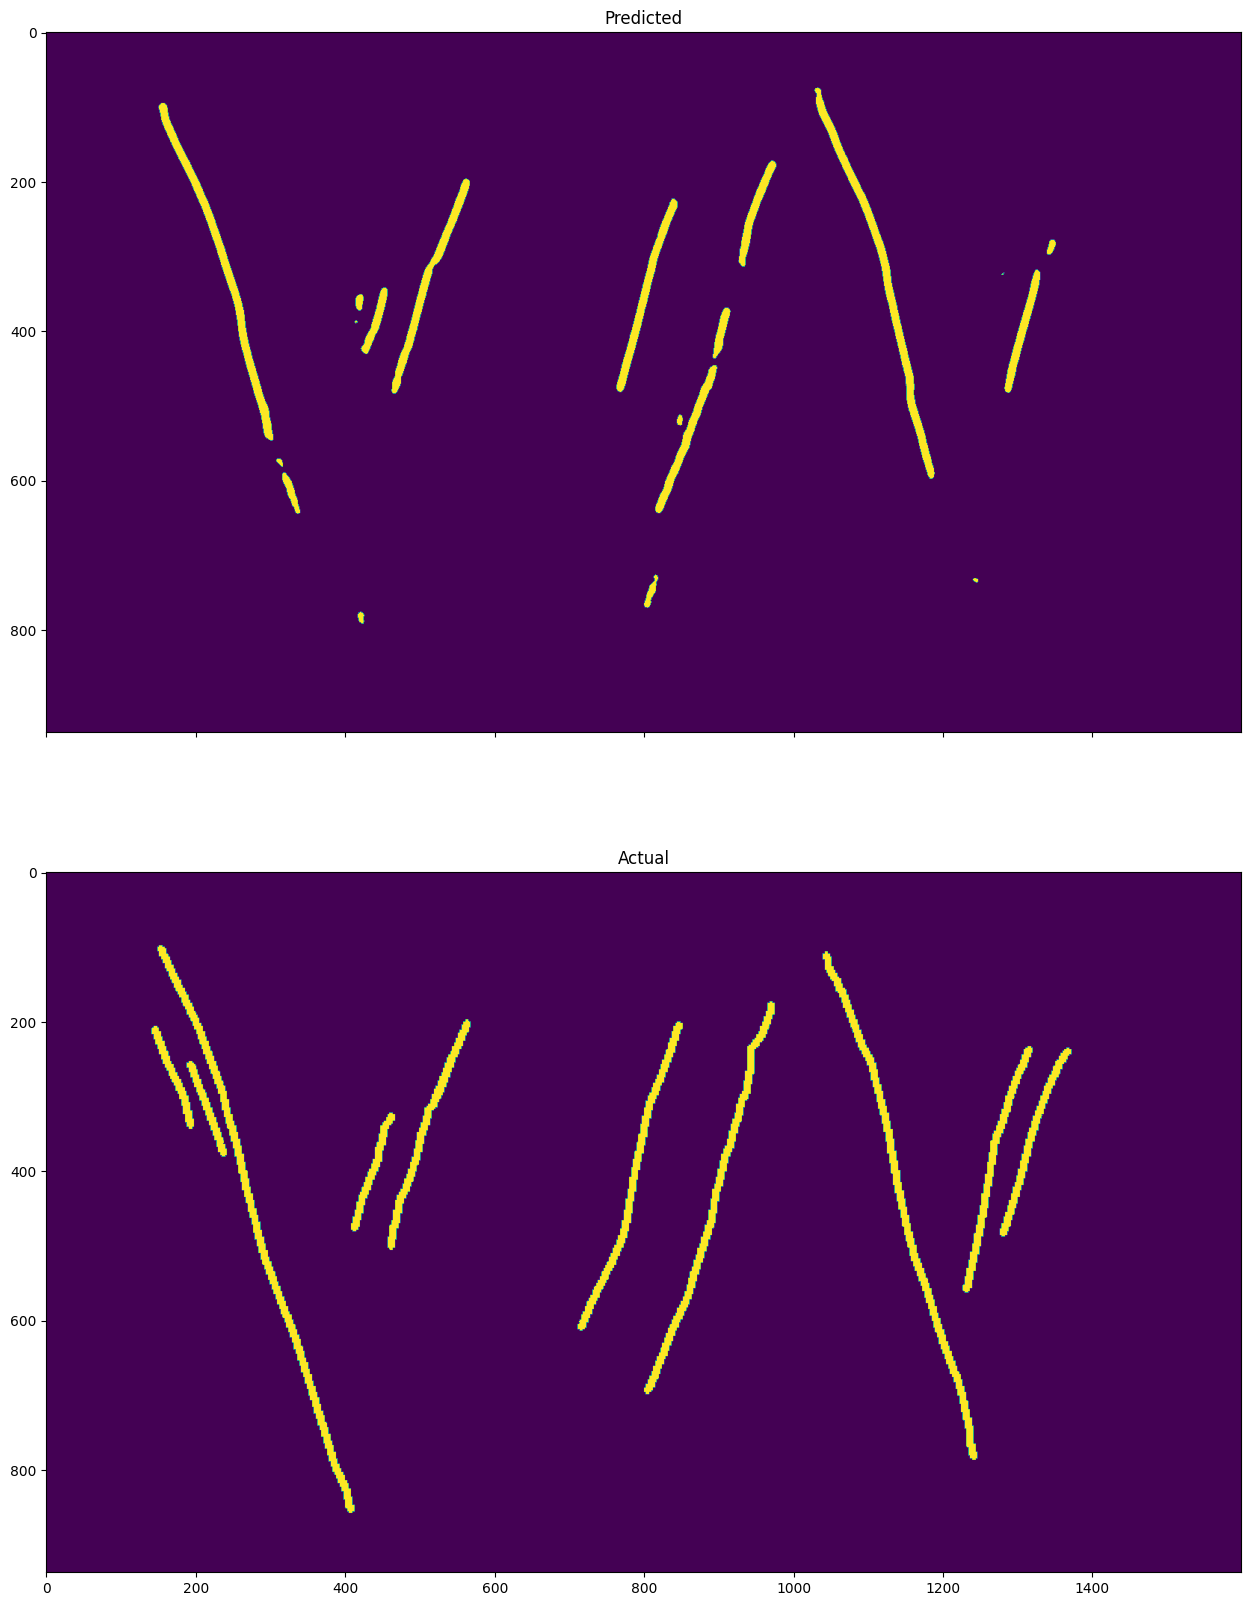

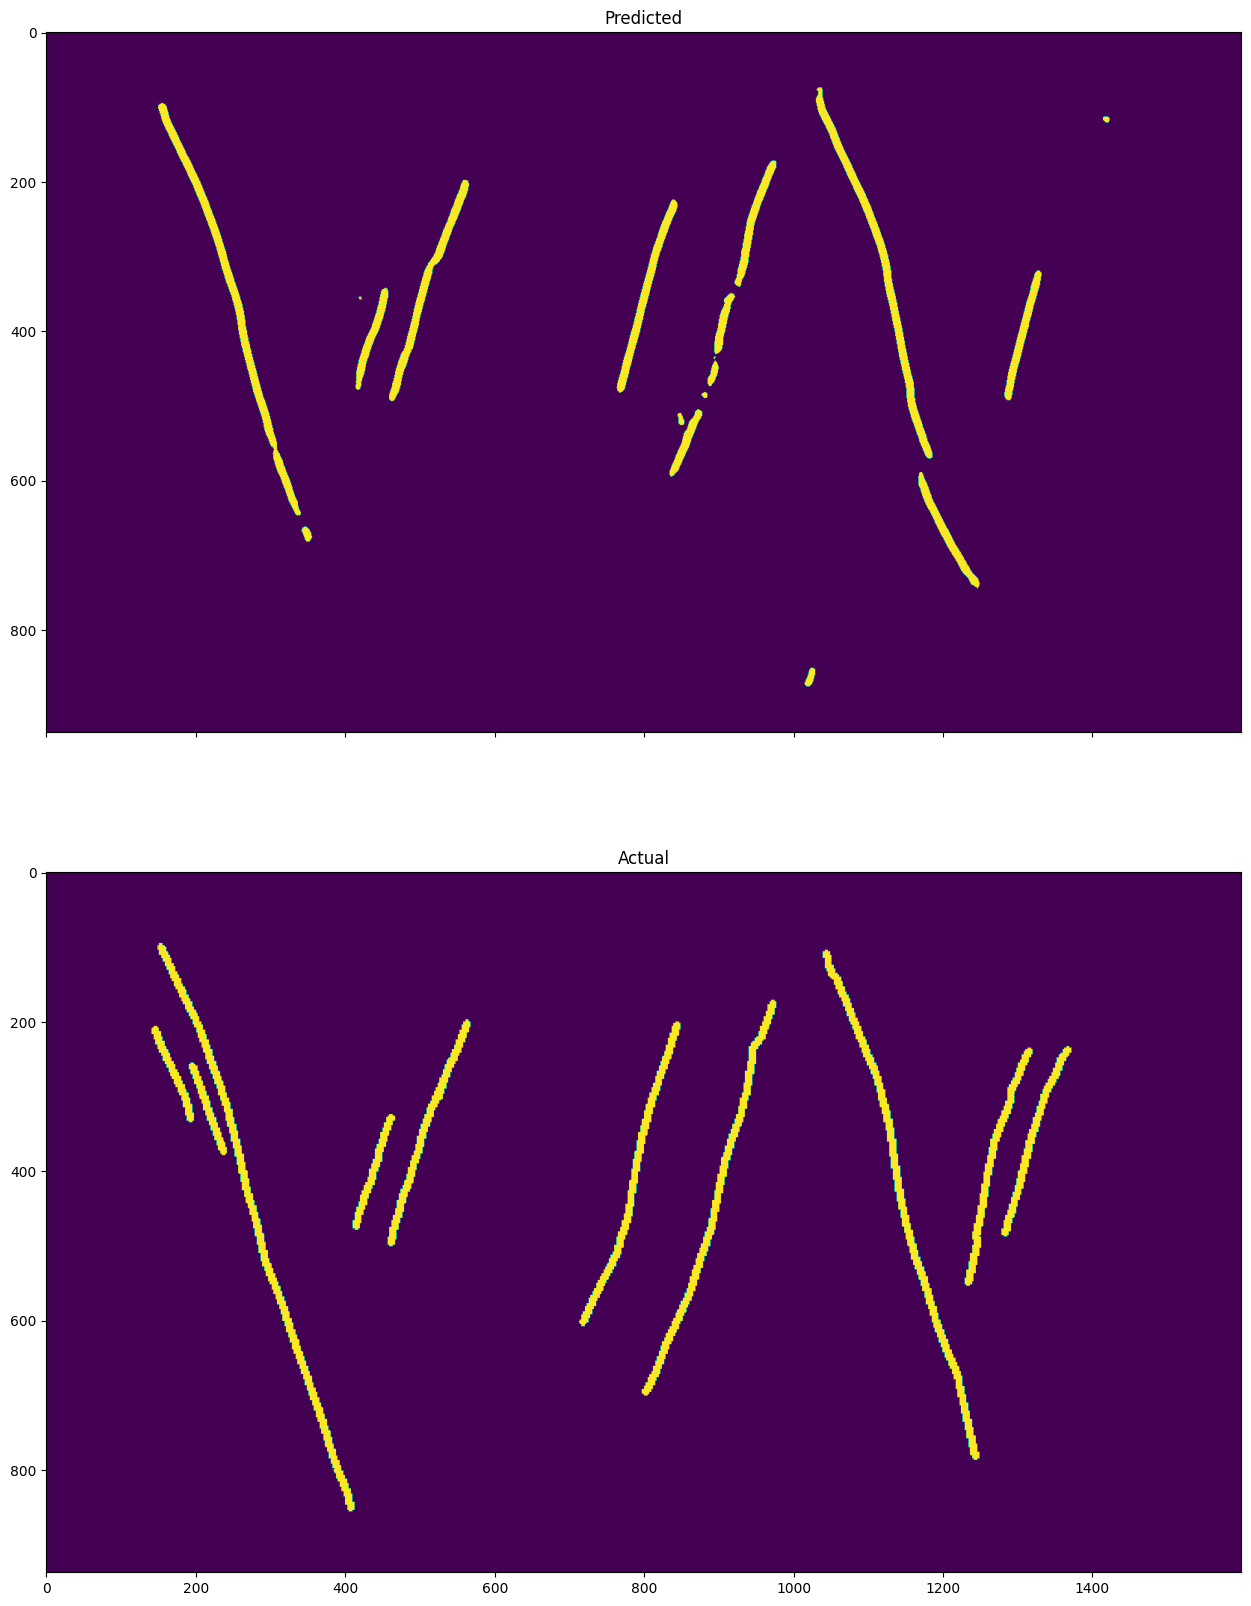

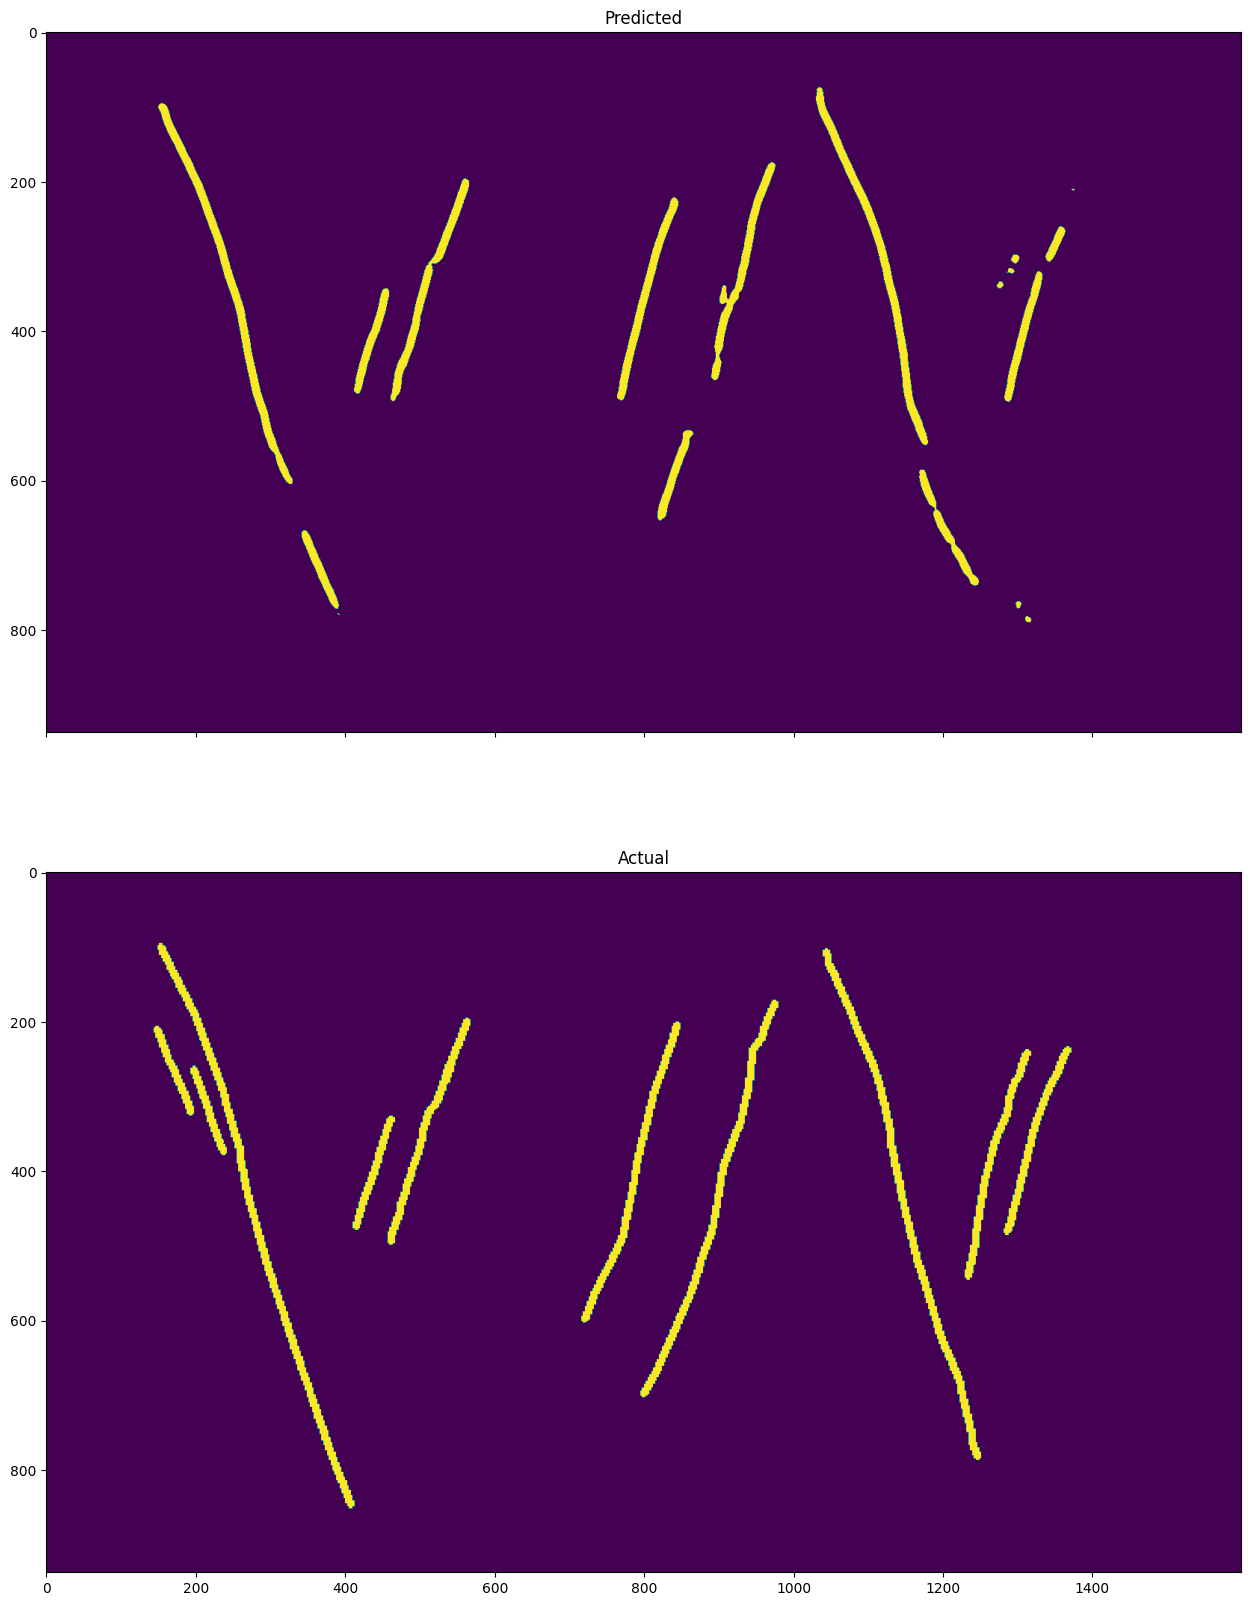

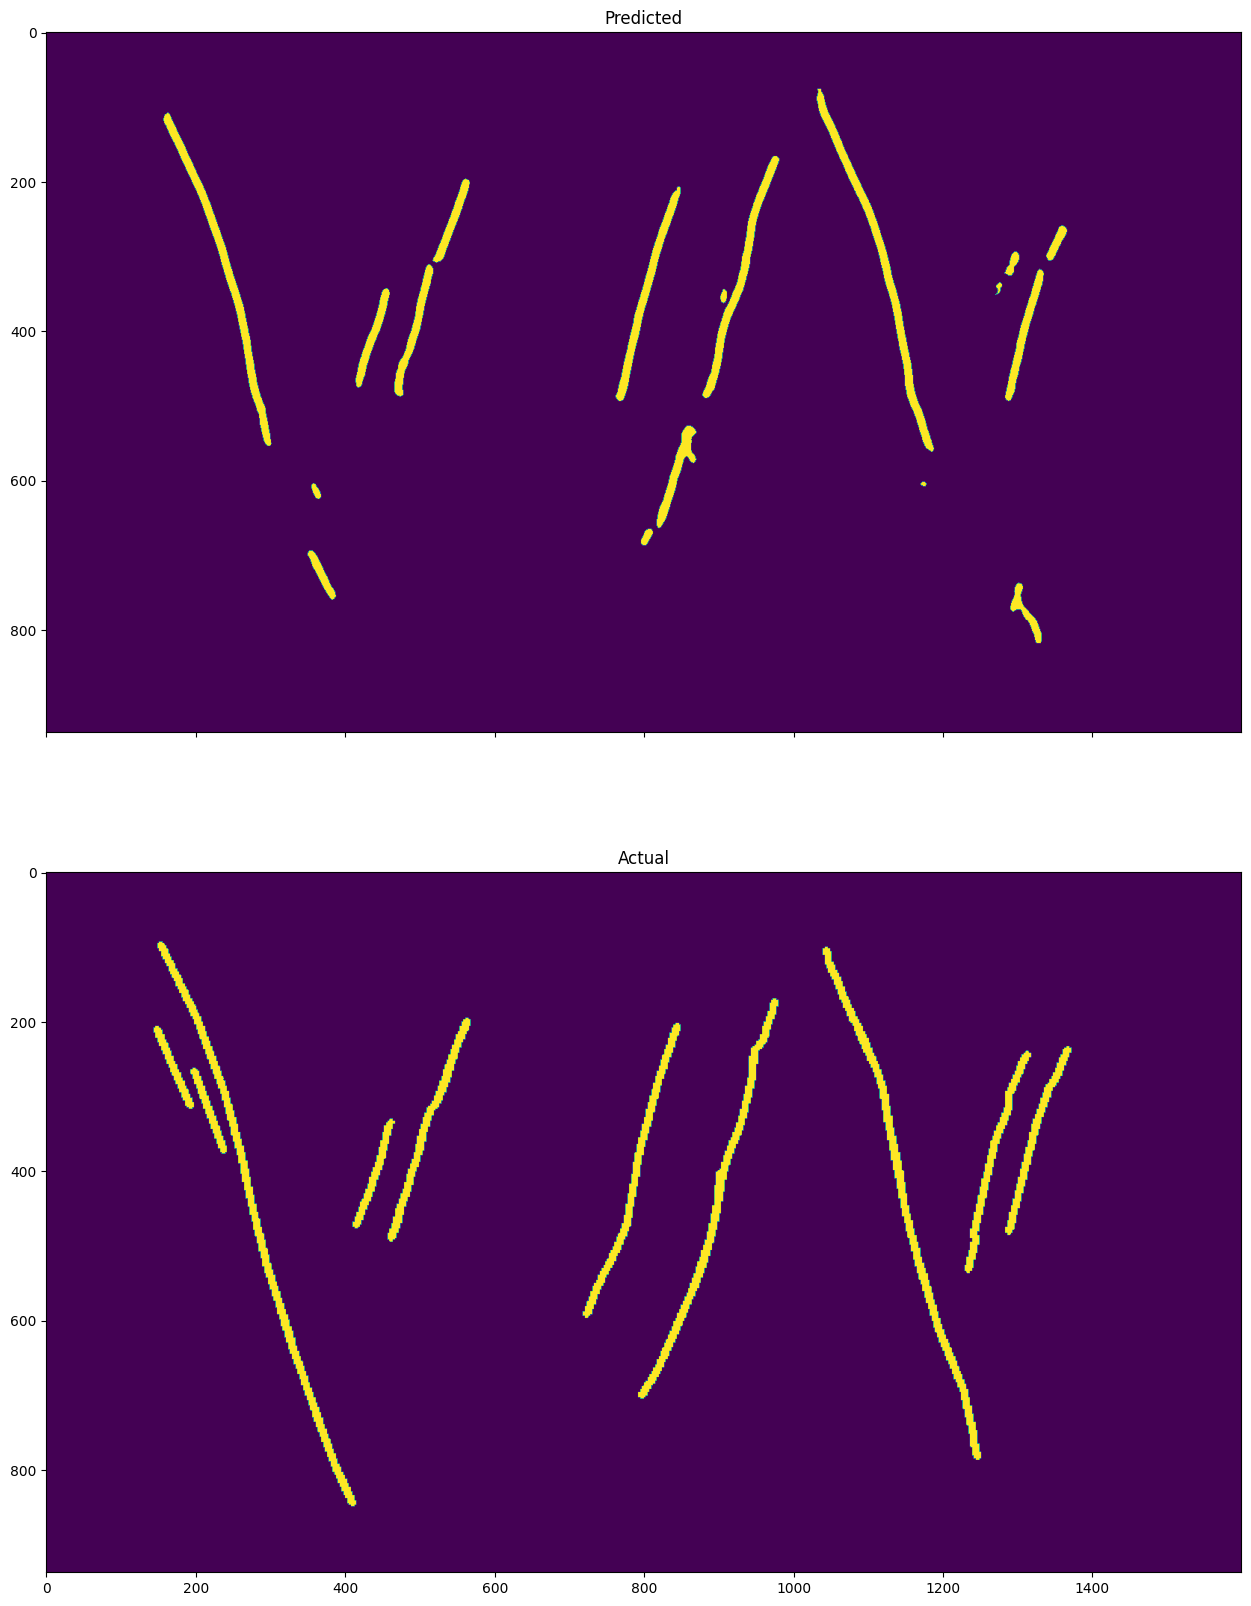

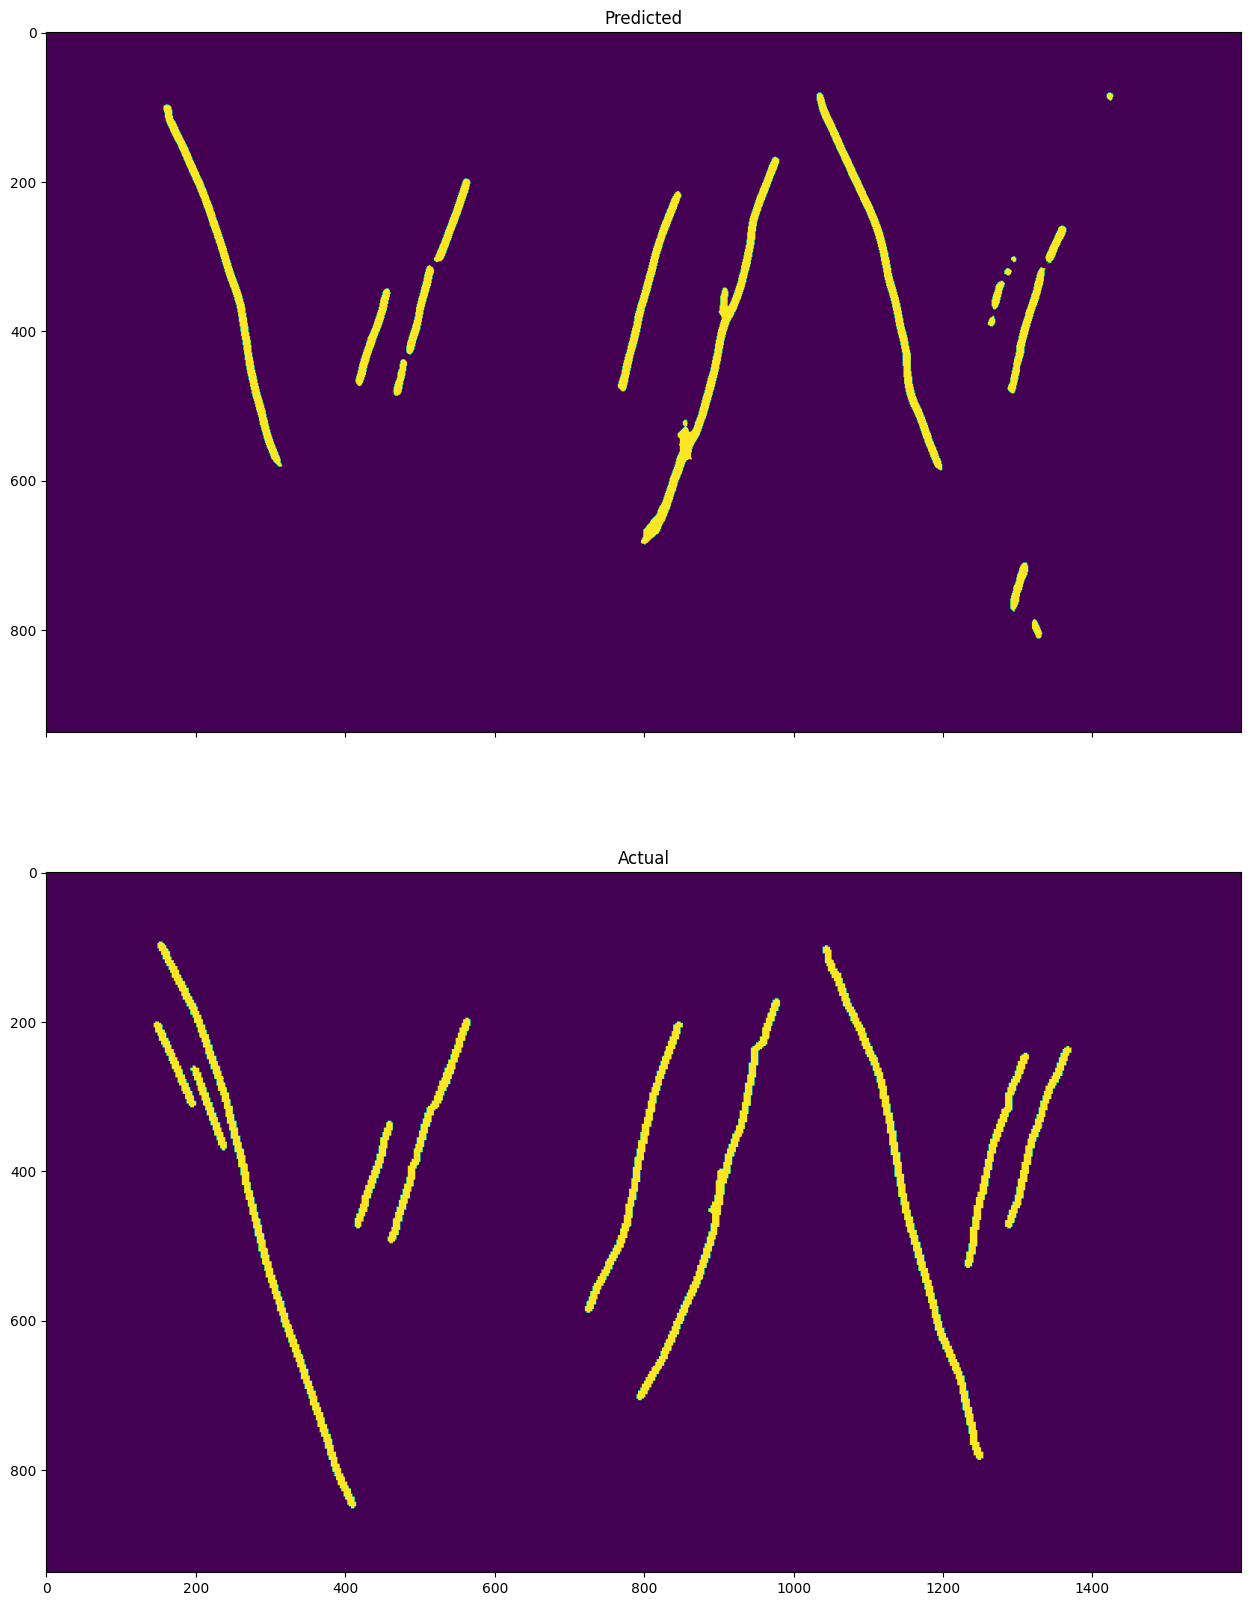

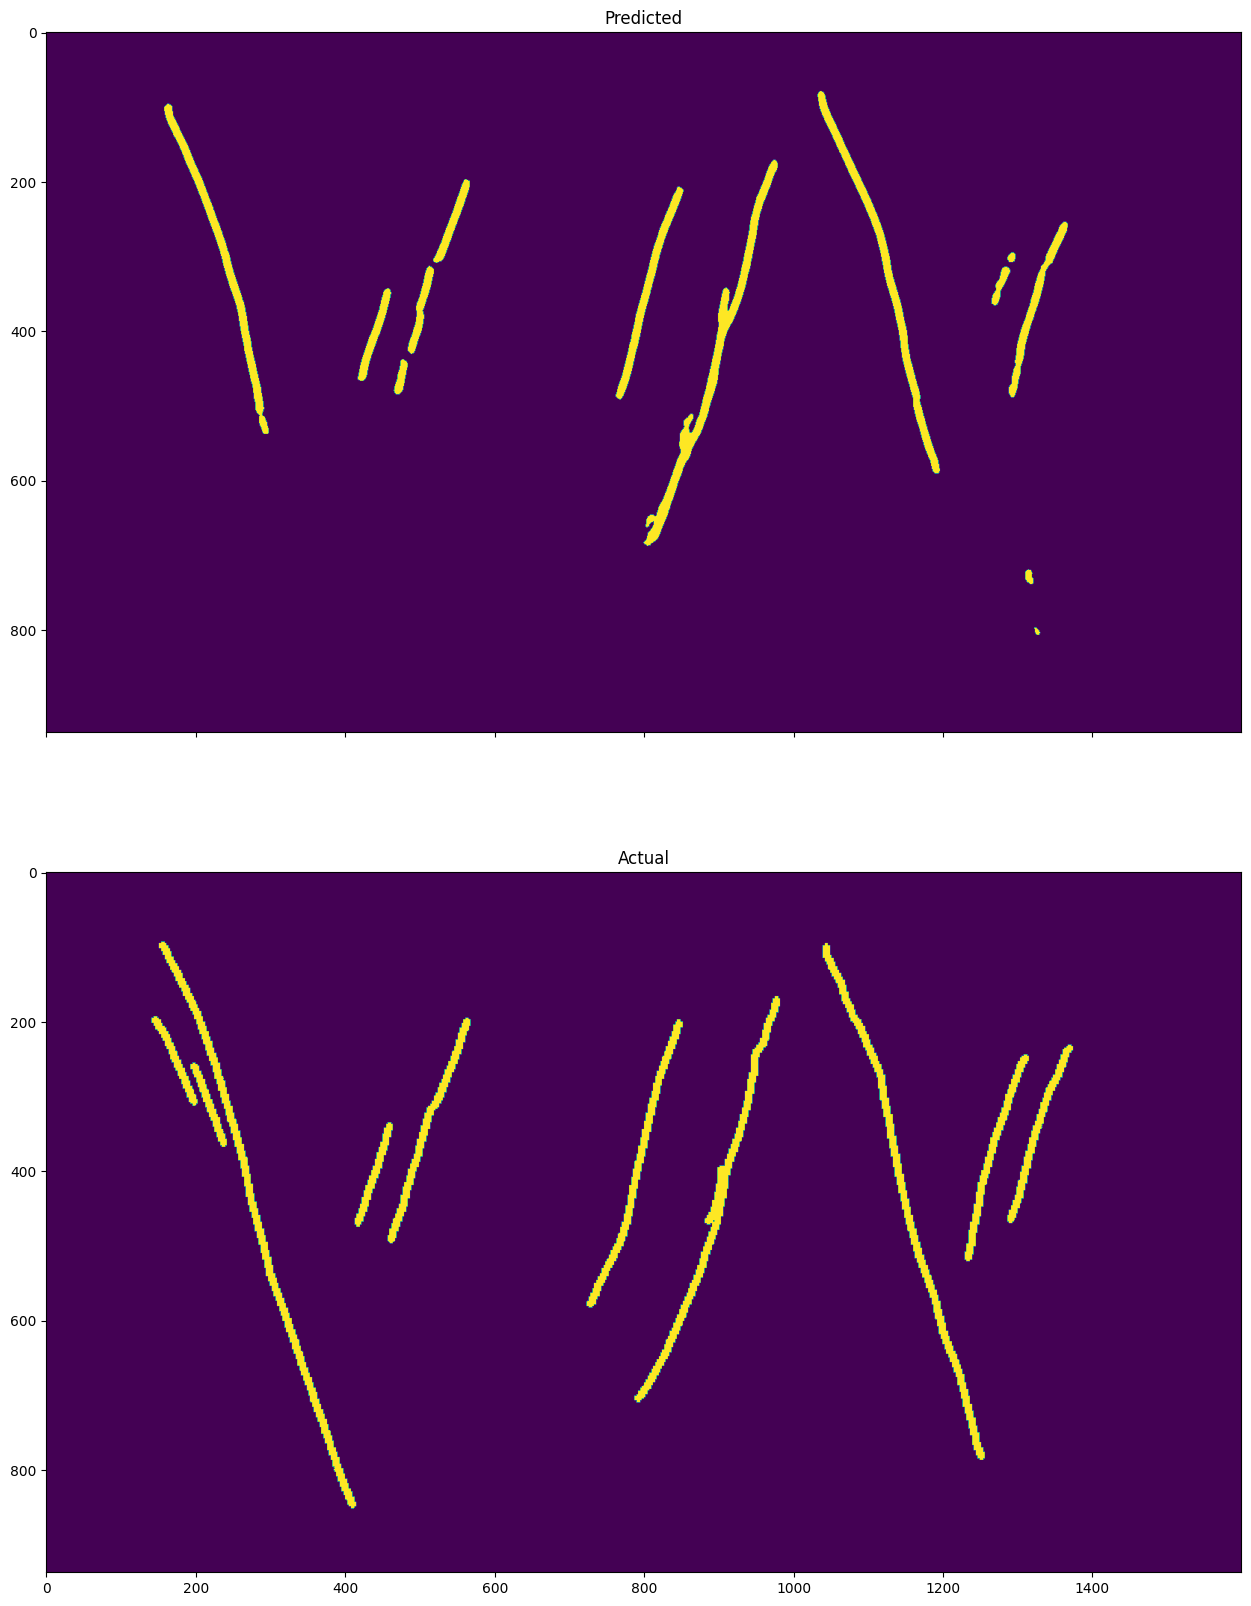

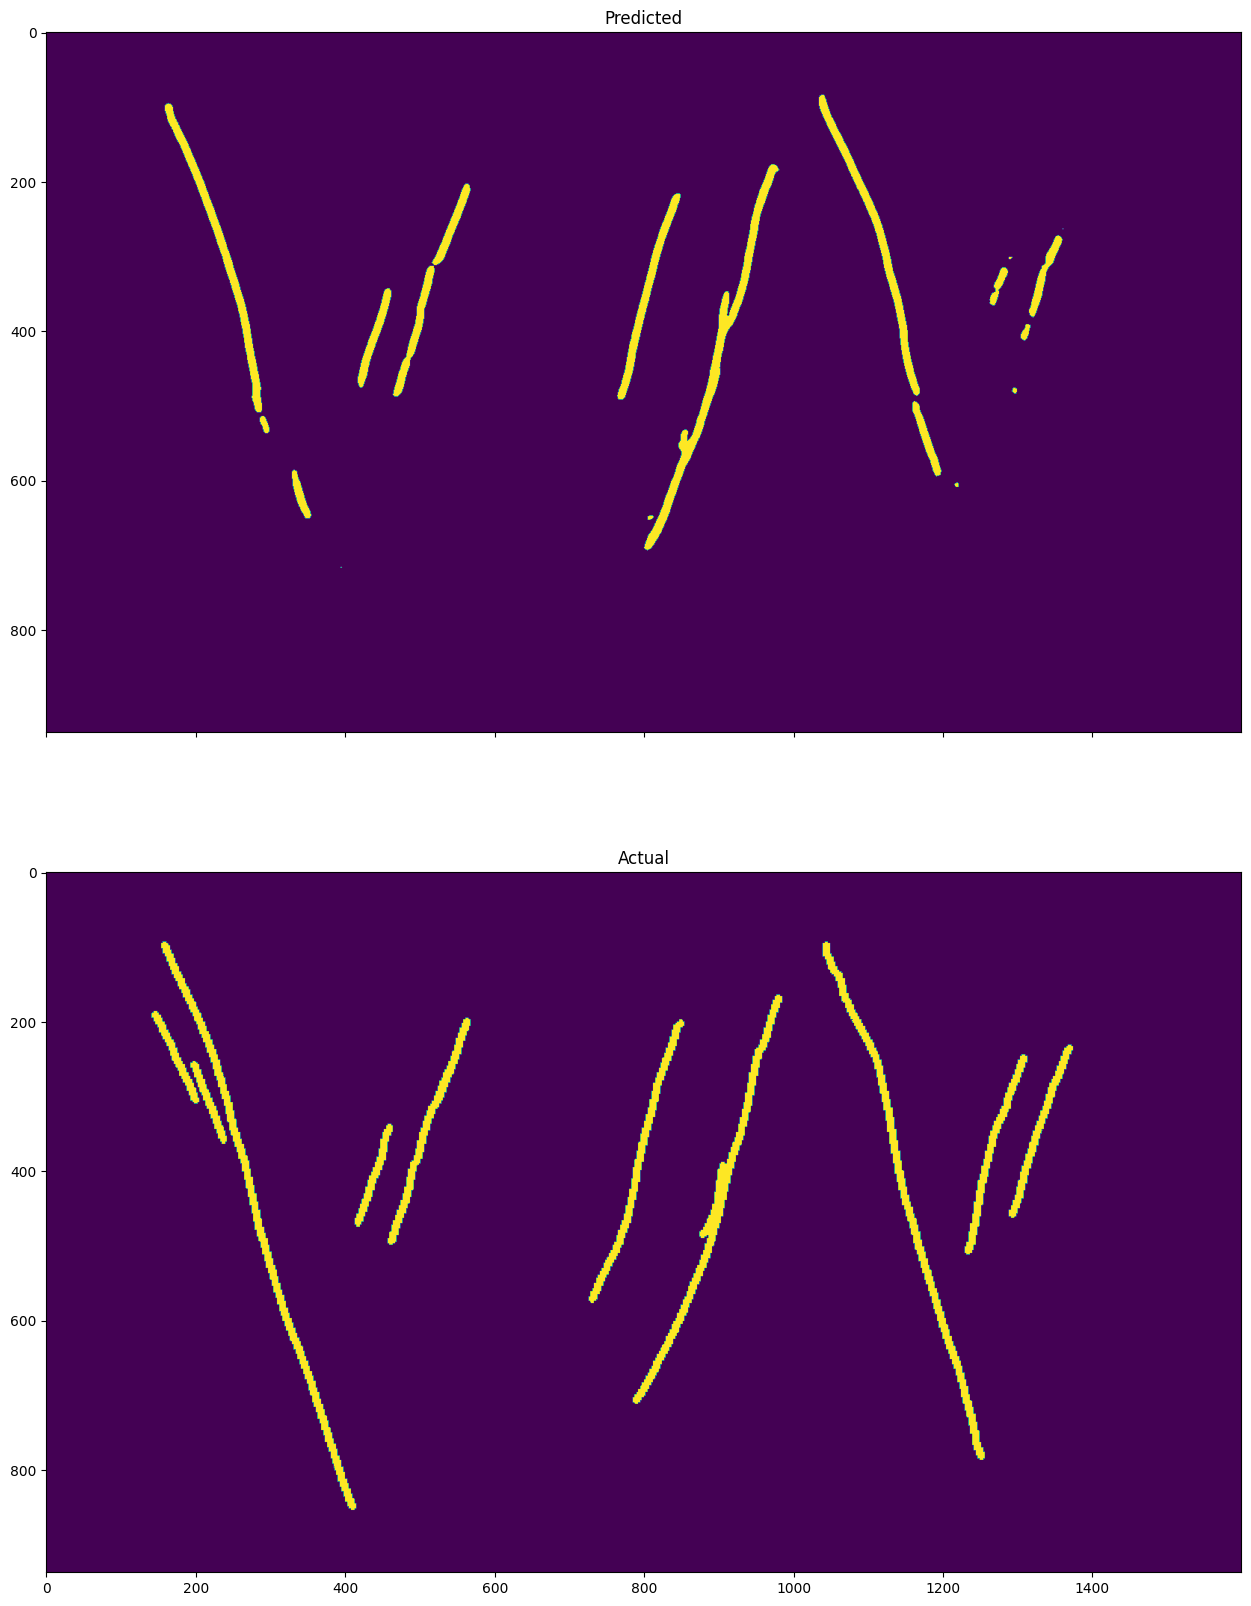

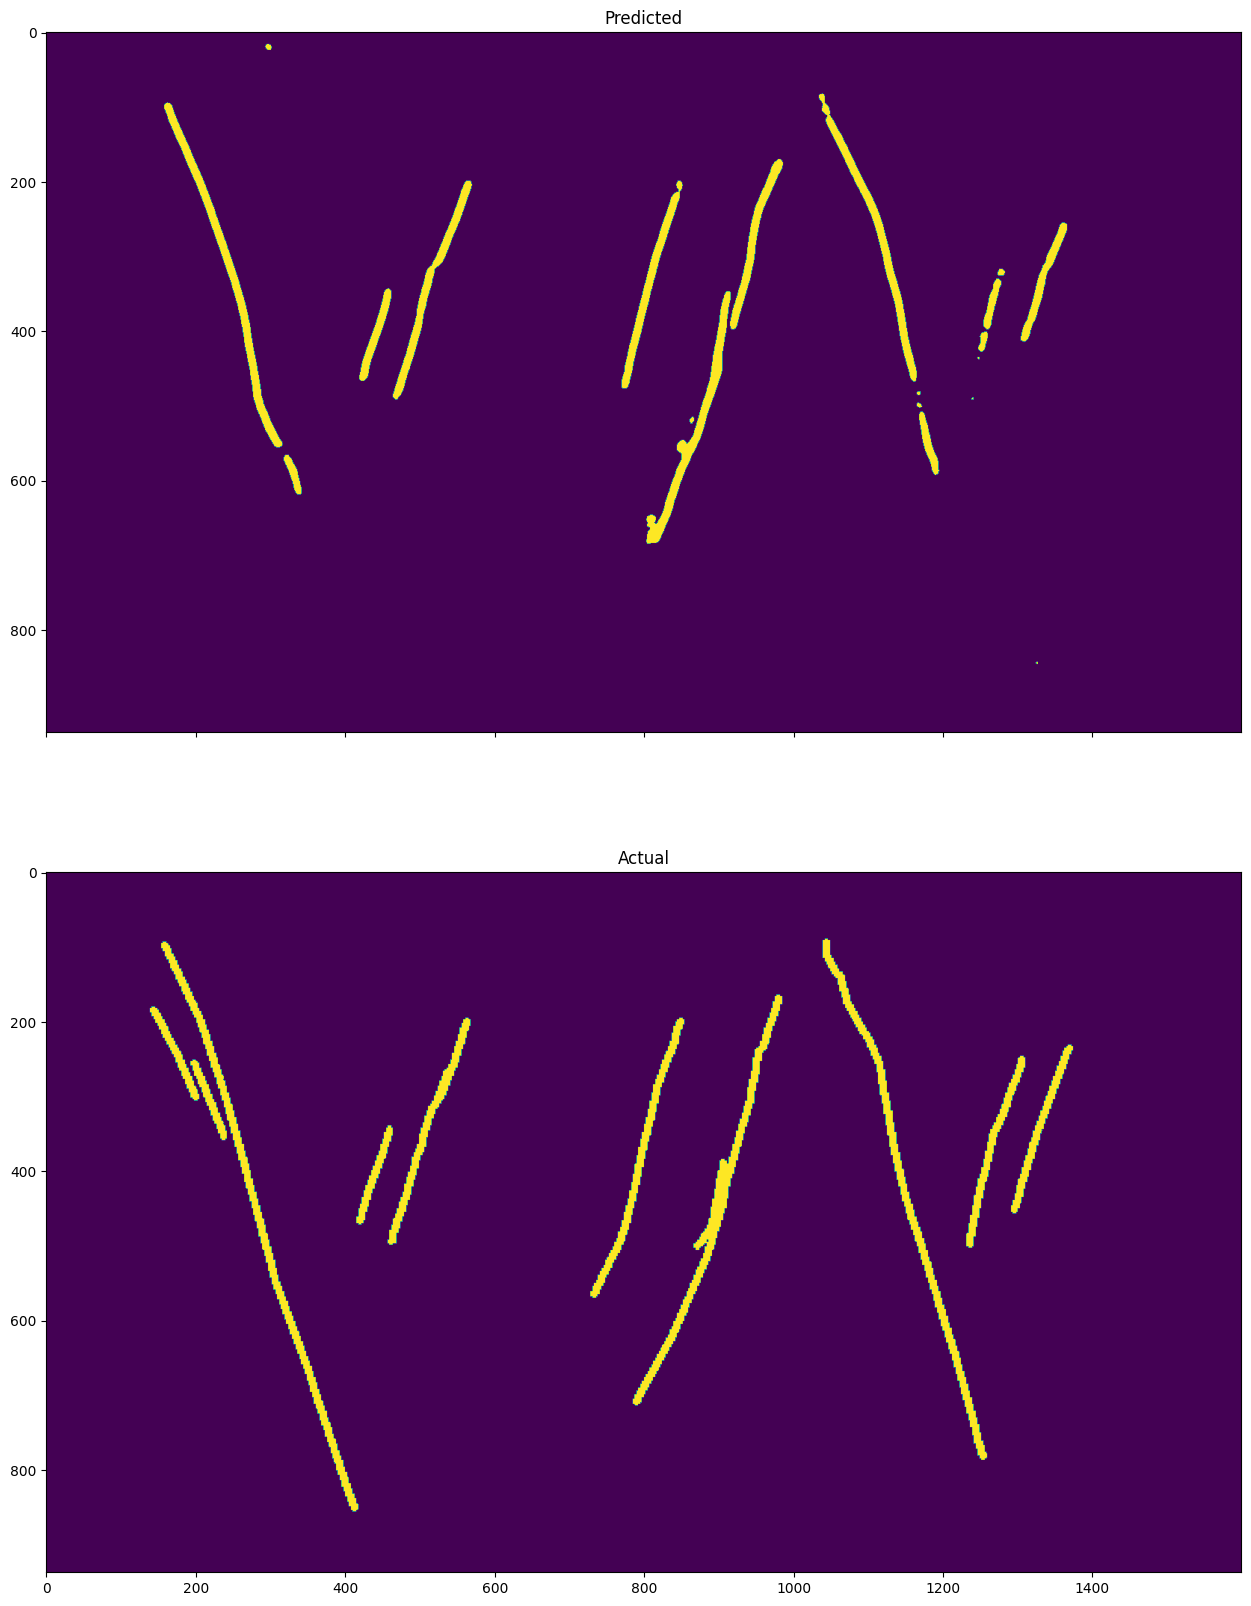

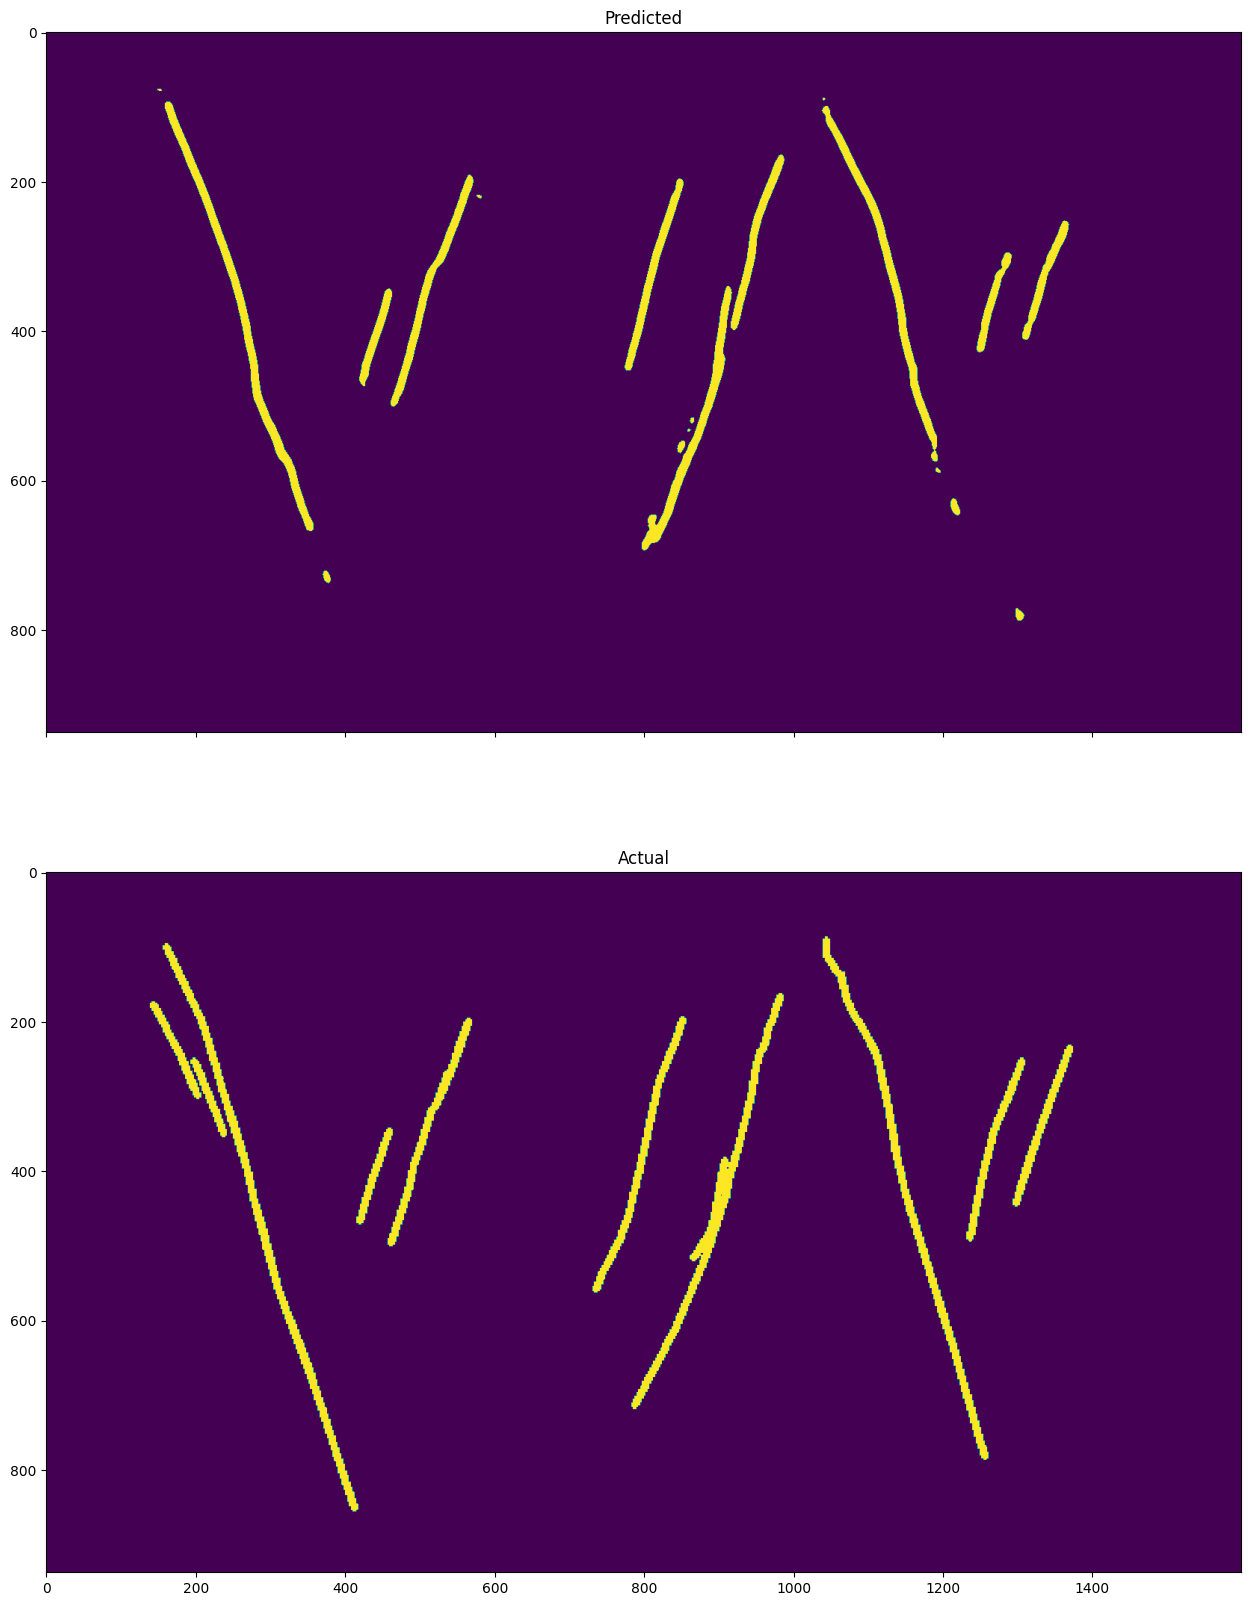

In [4]:
predict_horizon(model, "seistrain4.npz", "faulttrain4.npz", range(0, 11, 1), device, THRESHOLD, slicing=[600, None, 400, 2000], divisor=16)

## Мусор

In [ ]:
test_array = np.zeros((4, 5))
other_array = np.ones((3, 3))
test_array[:3, -3:] += other_array
test_array

In [ ]:
test_array = np.zeros((4, 5))
other_array = np.ones((3, 3))
test_array_x = 2
test_array_y = 0
for i in range(len(other_array)):
    for j in range(len(other_array[1])):
        test_array[test_array_y + i][test_array_x + j] += other_array[i][j]

# print(np.shape(test_array))
# # test_array[0: 3, 2: 5] += 
# test_array = np.sum(test_array[0: 3, 2: 5], other_array)
test_array

In [ ]:
c_array = [[i for i in range(5)] for j in range(4)]
c_array = np.array(c_array)
c_array

In [ ]:
np.shape(c_array[0: 4, :])